# Import Statements/Notebook Setup

In [1]:
OUTDATED_IGNORE = 1
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as mp
import os
from glob import glob
import seaborn as sns
from post_process import DataContainer
from scipy.stats import ttest_ind
import matplotlib.pyplot as plt
from scipy import stats
from collections import Counter
import warnings
import pingouin as pg
from SRhelper import op_stopping, stop, pfr, ros, conditional_ros, sps, fr_spc, murdock, lagCRP_curve, foelagCRP_curve, pos_outcomes_foeCRP, find_incorrect
from SRhelper import serposCRP, serposCRP_foe, FOE_stopping, rosdiff, RecConditionedStop, crp_nan_remover, eop_nan_remover, find_perfectstart, pstop_OPCorrect
import matplotlib.colors as colors

import statsmodels as sm
from statsmodels.stats.anova import AnovaRM

sns.set(style='ticks', context="talk")
os.getcwd()

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
%matplotlib inline

/home1/doughem/.conda/envs/AnalysisEnv/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/home1/doughem/.conda/envs/AnalysisEnv/lib/python3.8/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.0, the latest is 0.5.3.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(
/home1/doughem/.conda/envs/AnalysisEnv/lib/python3.8/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.1, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


# Data Import and Cleaning

## Data Import

In [2]:
paths_dict = {"experiment": 'serialrec_v2-4',
              'root': '/data/behavioral/mturk'}

container = DataContainer(**paths_dict)
start = container.get_cleaned_data()
subs = start[start['listno'] >= 4]

### Exclusionary Criteria

In [3]:
#Function for excluding participants who did not recall any items for a certain number of lists above a preset threshold, 
#set to 47 thereby excluding participants who did not recall for any test lists
def exclude_low(events, no_recalls_thresh=47):
    recalls_by_list = events[(events["type"] == 'WORD')].groupby("listno")["recalled"].sum()
    no_recall_lists = np.sum(recalls_by_list.values == 0)
    
    if no_recall_lists > no_recalls_thresh:
        return True

In [4]:
#Creates a list of subject IDs who meet exclusionary criteria as defined by above functions
lowlist = []
for i in subs.subject.unique():
    subject_df = subs[subs.subject == i]
    if(exclude_low(subject_df) == True):
        lowlist.append(subject_df.subject.iloc[0])

In [ ]:
#Exclude subjects based on the above criteria
subs = subs.query('subject not in @lowlist and subject in @english.updated_subject.unique()')
print("Total number of analyzable data sets: " + str(len(subs.subject.unique())))

### Demographic Information

In [4]:
#Reads in survey data from the same experiment, and creates a dataframe of those subjects who reported english as their first language.
#Data was manually parsed to ensure that misspellings of "English" and capitalization errors were not excluded.
survey_data = pd.read_csv('./survey_dataE5')
survey_data = survey_data.query('subject in @subs.subject.unique()')
# Exclude subjects based on the above criteria
# subs = subs.query('subject not in @lowlist')
print("Total number of analyzable data sets: " + str(len(subs.subject.unique())))
#Ensures that the subjects we are gathering demographic info from are the final subjects included in analysis
survey_data = survey_data.query('subject in @subs.subject.unique()')
#Exclude demographic information from anybody who has answered they are over 100 years old. Determined
#this cutoff from manual parsing of data.
print("Age Min: " + str(survey_data.query('question == "age"').response.astype(int).min()))
print("Age Max: " + str(survey_data.query('question == "age"').response.astype(int).max()))
print("Mean Age: " + str(survey_data.query('question == "age"').response.astype(int).mean()))
print("Age Standard Deviation: " + str(survey_data.query('question == "age"').response.astype(int).std()))
print(survey_data.query('question == "gender"').response.value_counts())

Total number of analyzable data sets: 552
Age Min: 19
Age Max: 84
Mean Age: 36.47826086956522
Age Standard Deviation: 11.991205120283938
Male                    284
Female                  266
Prefer not to answer      1
Name: response, dtype: int64


## Data Cleaning

In [7]:
#The data that comes in for this experiment encodes the "how" (aka fwd or bwd recall) and "when" (aka pre or post list pres)
#in the word events, but not in the recall events. This function assigns "how" and "when" values to the recall events (and 
#events that signify the start and end of recall) for purposes of later analysis. The second part of this function scores 
#correct recalls based on relative order scoring (correct if the recall prior was initially presented one prior in the case
#of fwd recall or one after in the case of backward). This function also creates a "repetition" column that is populated by
#0's and 1's for non-repeated and repeated items
def rec_assign(dataframe):
    warnings.filterwarnings('ignore') #ignore warnings that pandas gives me because it slows everything down
    dataframe['rel_recall'] = 0
    dataframe['repetition'] = 0
    assign_how = ''
    assign_when = ''
    rec_words = []
    for i in list(range(dataframe.shape[0])):
        if dataframe['type'].iloc[i] == 'START_RECALL':
            assign_how = dataframe['how'].iloc[i - 1] #grab the how value from the word event before the start of recall
            assign_when = dataframe['when'].iloc[i - 1] #grab the when value from the word event before the start of recall
            dataframe['how'].iloc[i] = assign_how
            dataframe['when'].iloc[i] = assign_when
            rec_words = []
            #note: because the 'REC_WORD' events below score the item one after their recall, first recalls must be accounted for here.
            if (dataframe['how'].iloc[i] == 'fwd') & (dataframe['serialpos'].iloc[i + 1] == 1.0):
                dataframe['rel_recall'].iloc[i + 1] = 1.0 #if serial pos of first recall in a fwd list == 1, correct
            elif (dataframe['how'].iloc[i] == 'bwd') & (dataframe['serialpos'].iloc[i + 1] == dataframe.list_length.iloc[i]):
                dataframe['rel_recall'].iloc[i + 1] = 1.0 #if serial pos of first recall in a fwd list == list length, correct
            continue 
        if dataframe['type'].iloc[i] == 'REC_WORD':
            dataframe['how'].iloc[i] = assign_how
            dataframe['when'].iloc[i] = assign_when
            if dataframe.intrusion.iloc[i] != 0:
                continue
            if dataframe['serialpos'].iloc[i] in rec_words:
                dataframe['repetition'].iloc[i] = 1
                continue
            rec_words.append(dataframe['serialpos'].iloc[i])
            if dataframe['serialpos'].iloc[i + 1] in rec_words:
                continue
            if dataframe['repetition'].iloc[i - 1] == 1:
                continue
            #here for relative recall, we score the following item, not the current. 
            if dataframe['how'].iloc[i] == 'fwd':
                if dataframe['serialpos'].iloc[i + 1] - dataframe['serialpos'].iloc[i] == 1.0:
                    #account for if the next item is the last recall event in the list
                    if (dataframe['type'].iloc[i + 2] == 'END_RECALL') & (dataframe['serialpos'].iloc[i + 1] == dataframe.list_length.iloc[i]):
                        dataframe['rel_recall'].iloc[i + 1] = 1.0
                        continue
                    dataframe['rel_recall'].iloc[i + 1] = 1.0
            if dataframe['how'].iloc[i] == 'bwd':
                if dataframe['serialpos'].iloc[i + 1] - dataframe['serialpos'].iloc[i] == -1.0:
                    #account for if the next item is the last recall event in the list
                    if (dataframe['type'].iloc[i + 2] == 'END_RECALL') & (dataframe['serialpos'].iloc[i + 1] == 1.0):
                        dataframe['rel_recall'].iloc[i + 1] = 1.0
                        continue
                    dataframe['rel_recall'].iloc[i + 1] = 1.0
        if dataframe['type'].iloc[i] == 'END_RECALL': 
            dataframe['how'].iloc[i] = assign_how
            dataframe['when'].iloc[i] = assign_when
            rec_words = []
    return dataframe

In [8]:
subs = rec_assign(subs)

In [9]:
#Data cleaning code takes a long time to load, so if you want to look at the data over multiple occurrences it is best to save the dataframe out as a CSV to avoid re-cleaning. 
subs.to_csv('./fullsubsE5.csv', index_label = 'index')

# Data Read-In, if already imported & cleaned

In [2]:
#Read-in of CSV if you want to avoid re-cleaning data.
subs = pd.read_csv('fullsubsE5.csv', index_col = 'index')
data_exclusions = subs.query('list_length > 12 | list_length < 6 ').subject.unique().tolist()
c2_incorrect = subs.query('list_length not in [6, 9, 12] and condition == 2.0').subject.unique().tolist()
c1_incorrect = subs.query('list_length not in [7, 9, 11] and condition == 1.0').subject.unique().tolist()
c0_incorrect = subs.query('list_length not in [8, 9, 10] and condition == 0.0').subject.unique().tolist()
sub_arrows = subs.query('item in ["→", "←"]').subject.unique().tolist()
sub_nans = subs.query('type == "REC_WORD" & item.isna() == True').subject.unique().tolist()
subs_exclude = set(sub_arrows + sub_nans)
data_exclusions = data_exclusions + c2_incorrect + c1_incorrect + c0_incorrect
subs = subs.query('subject not in @data_exclusions & subject not in @subs_exclude')
print(len(subs.subject.unique()))

552


# Running Analyses

## Repetitions

In [3]:
repno = []
for i in subs.subject.unique():
    sub_df = subs.query('subject == @i')
    reps = sub_df.repetition.sum()
    repxlist = reps/(sub_df.listno.max() - 3)
    repno.append(repxlist)
repetitions = sum(repno)/len(repno)
print("Total proportion of repetitions per list for a subject: " + str(repetitions))

Total proportion of repetitions per list for a subject: 0.04943911441388146


## Recall Probability

In [175]:
subs9 = subs.query('list_length == 9')
bwdlist = list(range(1, 10))
bwdlist.reverse() #create a list ordered from list_length to 1
store = -1 #create an integer variable that will later store the index position of the start of each recall list 
subs9['expected_outputpos'] = -999
#populate the expected output position column
for i in list(range(subs9.shape[0])):
    if subs9.type.iloc[i] == 'REC_WORD':
        if subs9.how.iloc[i] == 'fwd':
            subs9.expected_outputpos.iloc[i] = subs9.serialpos.iloc[i] #if fwd, expect fwd sequential recall
        if (subs9.how.iloc[i] == 'bwd') & (subs9.outpos.iloc[i] in bwdlist):
            subs9.expected_outputpos.iloc[i] = bwdlist[int(subs9.serialpos.iloc[i] - 1)] #if bwd, expect it bwd sequential recall

In [176]:
# Solway 9
rec_subs = subs9.query('rel_recall == 1')
word_subs = subs9.query('type == "WORD"')
solway_rate_df = pd.DataFrame(columns = ['subject', 'fwd_rec_rate', 'bwd_rec_rate'])
for sub in subs9.subject.unique():
    rec_sub_df = rec_subs.query('subject == @sub')
    word_sub_df = word_subs.query('subject == @sub')
    helper_list = []
    helper_list.append(sub)
    helper_list.append(rec_sub_df.query('how == "fwd"').shape[0]/word_sub_df.query('how == "fwd"').shape[0])
    helper_list.append(rec_sub_df.query('how == "bwd"').shape[0]/word_sub_df.query('how == "bwd"').shape[0])
    solway_rate_df = solway_rate_df.append(pd.Series(helper_list, index = ['subject', 'fwd_rec_rate', 'bwd_rec_rate']),
                                     ignore_index = True)

In [177]:
sol9p = stats.ttest_rel(solway_rate_df.fwd_rec_rate, solway_rate_df.bwd_rec_rate)[1]

In [178]:
# SPS
rec_subs = subs9.query('type == "REC_WORD" & outpos == expected_outputpos')
word_subs = subs9.query('type == "WORD"')
sps_rate_df = pd.DataFrame(columns = ['subject', 'fwd_rec_rate', 'bwd_rec_rate'])
for sub in subs9.subject.unique():
    rec_sub_df = rec_subs.query('subject == @sub')
    word_sub_df = word_subs.query('subject == @sub')
    helper_list = []
    helper_list.append(sub)
    helper_list.append(rec_sub_df.query('how == "fwd"').shape[0]/word_sub_df.query('how == "fwd"').shape[0])
    helper_list.append(rec_sub_df.query('how == "bwd"').shape[0]/word_sub_df.query('how == "bwd"').shape[0])
    sps_rate_df = sps_rate_df.append(pd.Series(helper_list, index = ['subject', 'fwd_rec_rate', 'bwd_rec_rate']),
                                     ignore_index = True)

In [179]:
sps9p = stats.ttest_rel(sps_rate_df.fwd_rec_rate, sps_rate_df.bwd_rec_rate)[1]

In [180]:
# FR
rec_subs = subs9.query('type == "REC_WORD" & repetition != 1.0 & intrusion == 0.0')
word_subs = subs9.query('type == "WORD"')
fr_rate_df = pd.DataFrame(columns = ['subject', 'fwd_rec_rate', 'bwd_rec_rate'])
for sub in subs9.subject.unique():
    rec_sub_df = rec_subs.query('subject == @sub')
    word_sub_df = word_subs.query('subject == @sub')
    helper_list = []
    helper_list.append(sub)
    helper_list.append(rec_sub_df.query('how == "fwd"').shape[0]/word_sub_df.query('how == "fwd"').shape[0])
    helper_list.append(rec_sub_df.query('how == "bwd"').shape[0]/word_sub_df.query('how == "bwd"').shape[0])
    fr_rate_df = fr_rate_df.append(pd.Series(helper_list, index = ['subject', 'fwd_rec_rate', 'bwd_rec_rate']),
                                     ignore_index = True)

In [181]:
fr9p = stats.ttest_rel(fr_rate_df.fwd_rec_rate, fr_rate_df.bwd_rec_rate)[1]

In [182]:
# Murdock: 
murdfwd = murdock(subs, 9, how = 'fwd')
murdbwd = murdock(subs, 9, how = 'bwd', flip_bwd = True)
murdfwd1 = murdfwd[['subject', 'actual_count', 'possible_count', 'how']].groupby('subject').agg({'actual_count': 'sum', 'possible_count':'sum'})
murdbwd1 = murdbwd[['subject', 'actual_count', 'possible_count', 'how']].groupby('subject').agg({'actual_count': 'sum', 'possible_count':'sum'})

In [183]:
murd9p = stats.ttest_rel(murdfwd1.actual_count/murdfwd1.possible_count, murdbwd1.actual_count/murdbwd1.possible_count)[1]

In [184]:
# COS: 
cosfwd = conditional_ros(subs, 9, how = 'fwd')
cosbwd = conditional_ros(subs, 9, how = 'bwd', flip_bwd = True)

In [185]:
cosfwd1 = cosfwd[['subject', 'actual_count', 'possible_count', 'how']].groupby('subject').agg({'actual_count': 'sum', 'possible_count':'sum'})
cosbwd1 = cosbwd[['subject', 'actual_count', 'possible_count', 'how']].groupby('subject').agg({'actual_count': 'sum', 'possible_count':'sum'})

In [186]:
cos9p = stats.ttest_rel(cosfwd1.actual_count/cosfwd1.possible_count, cosbwd1.actual_count/cosbwd1.possible_count)[1]

In [191]:
pvals = [sol9p, murd9p, fr9p, cos9p, sps9p]
print(pvals)
sm.stats.multitest.fdrcorrection(pvals, alpha = 0.05)

[0.2730075821834505, 0.7790799772638892, 0.31913040508597473, 0.010757300289854669, 0.22560133579674668]


(array([False, False, False, False, False]),
 array([0.39891301, 0.77907998, 0.39891301, 0.0537865 , 0.39891301]))

In [188]:
fwd_scores = [solway_rate_df.fwd_rec_rate.mean(), (murdfwd1.actual_count/murdfwd1.possible_count).mean(), fr_rate_df.fwd_rec_rate.mean(), 
              (cosfwd1.actual_count/cosfwd1.possible_count).mean(), sps_rate_df.fwd_rec_rate.mean()]

In [189]:
bwd_scores = [solway_rate_df.bwd_rec_rate.mean(), (murdbwd1.actual_count/murdbwd1.possible_count).mean(), fr_rate_df.bwd_rec_rate.mean(), 
              (cosbwd1.actual_count/cosbwd1.possible_count).mean(), sps_rate_df.bwd_rec_rate.mean()]

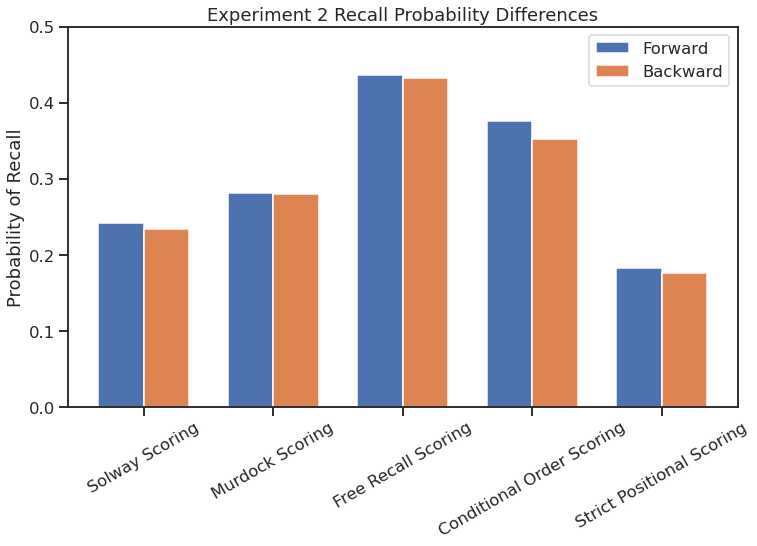

In [190]:
fig, ax = plt.subplots(figsize = (12,7))

labels = ['Solway Scoring', 'Murdock Scoring', 'Free Recall Scoring', 'Conditional Order Scoring', 'Strict Positional Scoring']

x = np.arange(len(labels))
width = 0.35  # the width of the bars

fwd = ax.bar(x - width/2, fwd_scores, width, label='Forward')
bwd = ax.bar(x + width/2, bwd_scores, width, label='Backward')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Probability of Recall')
ax.set_xticks(x)
ax.set_ylim([0, 0.5])
ax.set_xticklabels(labels)
plt.xticks(rotation = 30)
ax.set_title('Experiment 2 Recall Probability Differences')
ax.legend()
fig.savefig("./../graphsE5/FinalSPC/Compare_Methods.pdf", bbox_inches = 'tight',pad_inches = 0.2)

## Serial/Output Position

In [20]:
rosfwd9 = ros(subs, 9, how = 'fwd')
rosbwd9 = ros(subs, 9, how = 'bwd')
rosbwd9flip = ros(subs, 9, how = 'bwd', flip_bwd = True)

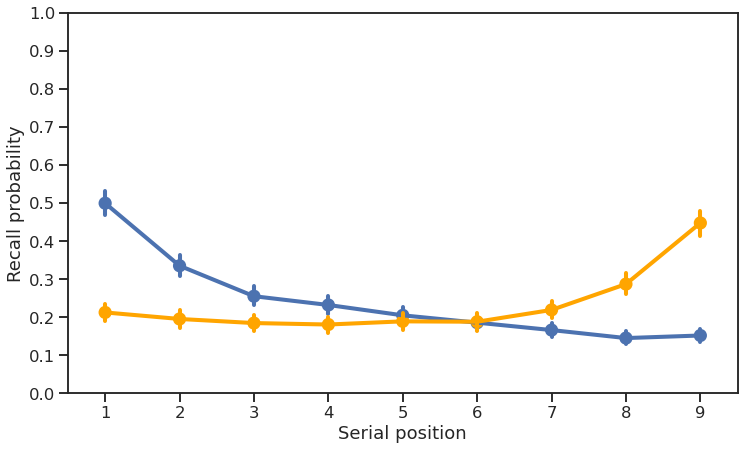

In [21]:
ros9fwdfig= plt.figure(figsize = (12, 7))
ax1 = sns.pointplot(data=rosfwd9, x='x_values', y='probability', marker = 'o')
ax2 = sns.pointplot(data=rosbwd9, x='x_values', y='probability', marker = 'o', color = 'orange')
plt.xlabel('Serial position')
plt.ylabel('Recall probability')
ax1.set_yticks([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
ros9fwdfig.savefig("./../graphsE5/FinalSPC/Collapsed_SPC.pdf", bbox_inches = 'tight',pad_inches = 0.2)

In [3]:
solwayfwd = ros(subs, 9, how = 'fwd')
solwaybwd = ros(subs, 9, how = 'bwd', flip_bwd = True)
rosfwd = conditional_ros(subs, 9, how = 'fwd')
rosbwd = conditional_ros(subs, 9, how = 'bwd', flip_bwd = True)
frfwd = fr_spc(subs, 9, how = 'fwd')
frbwd = fr_spc(subs, 9, how = 'bwd', flip_bwd = True)
murdockfwd = murdock(subs, 9, how = 'fwd')
murdockbwd = murdock(subs, 9, how = 'bwd', flip_bwd = True)
spsfwd = sps(subs, 9, how = 'fwd')
spsbwd = sps(subs, 9, how = 'bwd', flip_bwd = True)

In [4]:
statsps9 = pd.concat([spsfwd, spsbwd])
statros9 = pd.concat([rosfwd, rosbwd])
statfr9 = pd.concat([frfwd, frbwd])
statmurdock9 = pd.concat([murdockfwd, murdockbwd])
statsolway9 = pd.concat([solwayfwd, solwaybwd])

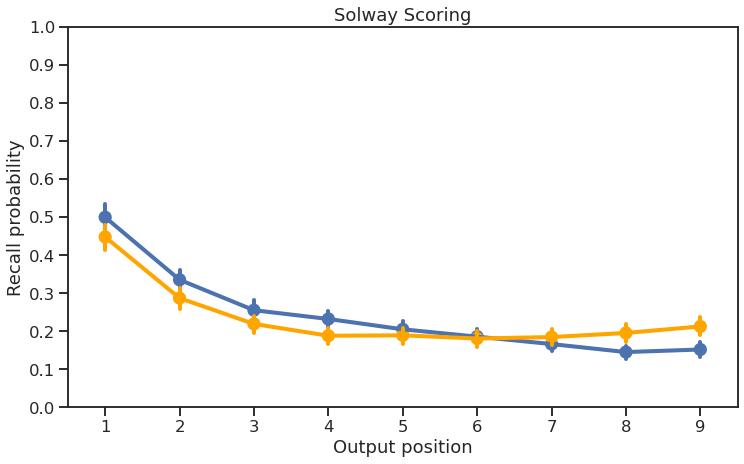

In [5]:
solwayfig = plt.figure(figsize = (12, 7))
ax1 = sns.pointplot(data=solwayfwd, x='x_values', y='probability', marker = 'o')
ax2 = sns.pointplot(data=solwaybwd, x='x_values', y='probability', marker = 'o', color = 'orange')
plt.xlabel('Output position')
plt.ylabel('Recall probability')
ax1.set_yticks([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
plt.title('Solway Scoring')
solwayfig.savefig("./../graphsE5/FinalSPC/solwayE2collapse.pdf", bbox_inches = 'tight',pad_inches = 0.2)

In [6]:
fbsolway1 = stats.ttest_rel(statsolway9[(statsolway9.x_values == 1) & (statsolway9.how == 'bwd')].probability, statsolway9[(statsolway9.x_values == 1) & (statsolway9.how == 'fwd')].probability)[1]
fbsolway2 = stats.ttest_rel(statsolway9[(statsolway9.x_values == 2) & (statsolway9.how == 'bwd')].probability, statsolway9[(statsolway9.x_values == 2) & (statsolway9.how == 'fwd')].probability)[1]
fbsolway3 = stats.ttest_rel(statsolway9[(statsolway9.x_values == 3) & (statsolway9.how == 'bwd')].probability, statsolway9[(statsolway9.x_values == 3) & (statsolway9.how == 'fwd')].probability)[1]
fbsolway4 = stats.ttest_rel(statsolway9[(statsolway9.x_values == 4) & (statsolway9.how == 'bwd')].probability, statsolway9[(statsolway9.x_values == 4) & (statsolway9.how == 'fwd')].probability)[1]
fbsolway5 = stats.ttest_rel(statsolway9[(statsolway9.x_values == 5) & (statsolway9.how == 'bwd')].probability, statsolway9[(statsolway9.x_values == 5) & (statsolway9.how == 'fwd')].probability)[1]
fbsolway6 = stats.ttest_rel(statsolway9[(statsolway9.x_values == 6) & (statsolway9.how == 'bwd')].probability, statsolway9[(statsolway9.x_values == 6) & (statsolway9.how == 'fwd')].probability)[1]
fbsolway7 = stats.ttest_rel(statsolway9[(statsolway9.x_values == 7) & (statsolway9.how == 'bwd')].probability, statsolway9[(statsolway9.x_values == 7) & (statsolway9.how == 'fwd')].probability)[1]
fbsolway8 = stats.ttest_rel(statsolway9[(statsolway9.x_values == 8) & (statsolway9.how == 'bwd')].probability, statsolway9[(statsolway9.x_values == 8) & (statsolway9.how == 'fwd')].probability)[1]
fbsolway9 = stats.ttest_rel(statsolway9[(statsolway9.x_values == 9) & (statsolway9.how == 'bwd')].probability, statsolway9[(statsolway9.x_values == 9) & (statsolway9.how == 'fwd')].probability)[1]
solway_correct = [fbsolway1,fbsolway2,fbsolway3,fbsolway4,fbsolway5,fbsolway6,fbsolway7,fbsolway8,fbsolway9]
print(sm.stats.multitest.fdrcorrection(solway_correct, alpha = 0.05))
print(sm.stats.multitest.fdrcorrection(solway_correct, alpha = 0.001))

(array([ True,  True,  True,  True, False, False,  True,  True,  True]), array([6.52351274e-04, 3.69995916e-04, 2.59634774e-03, 5.18359106e-05,
       1.01055909e-01, 5.90737725e-01, 4.83416998e-02, 6.08520844e-07,
       2.77223678e-09]))
(array([ True,  True, False,  True, False, False, False,  True,  True]), array([6.52351274e-04, 3.69995916e-04, 2.59634774e-03, 5.18359106e-05,
       1.01055909e-01, 5.90737725e-01, 4.83416998e-02, 6.08520844e-07,
       2.77223678e-09]))


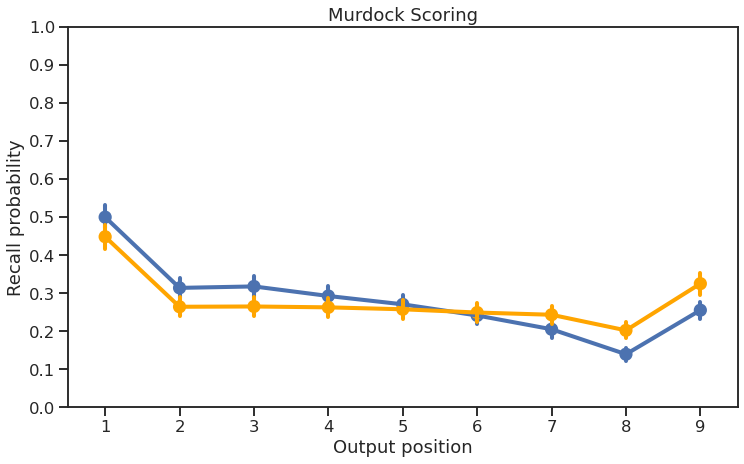

In [7]:
murdockfig = plt.figure(figsize = (12, 7))
ax1 = sns.pointplot(data=murdockfwd, x='x_values', y='probability', marker = 'o')
ax2 = sns.pointplot(data=murdockbwd, x='x_values', y='probability', marker = 'o', color = 'orange')
plt.xlabel('Output position')
plt.ylabel('Recall probability')
ax1.set_yticks([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
plt.title('Murdock Scoring')
murdockfig.savefig("./../graphsE5/FinalSPC/murdockE2collapse.pdf", bbox_inches = 'tight',pad_inches = 0.2)

In [9]:
fbmurdock1 = stats.ttest_rel(statmurdock9[(statmurdock9.x_values == 1) & (statmurdock9.how == 'bwd')].probability, statmurdock9[(statmurdock9.x_values == 1) & (statmurdock9.how == 'fwd')].probability)[1]
fbmurdock2 = stats.ttest_rel(statmurdock9[(statmurdock9.x_values == 2) & (statmurdock9.how == 'bwd')].probability, statmurdock9[(statmurdock9.x_values == 2) & (statmurdock9.how == 'fwd')].probability)[1]
fbmurdock3 = stats.ttest_rel(statmurdock9[(statmurdock9.x_values == 3) & (statmurdock9.how == 'bwd')].probability, statmurdock9[(statmurdock9.x_values == 3) & (statmurdock9.how == 'fwd')].probability)[1]
fbmurdock4 = stats.ttest_rel(statmurdock9[(statmurdock9.x_values == 4) & (statmurdock9.how == 'bwd')].probability, statmurdock9[(statmurdock9.x_values == 4) & (statmurdock9.how == 'fwd')].probability)[1]
fbmurdock5 = stats.ttest_rel(statmurdock9[(statmurdock9.x_values == 5) & (statmurdock9.how == 'bwd')].probability, statmurdock9[(statmurdock9.x_values == 5) & (statmurdock9.how == 'fwd')].probability)[1]
fbmurdock6 = stats.ttest_rel(statmurdock9[(statmurdock9.x_values == 6) & (statmurdock9.how == 'bwd')].probability, statmurdock9[(statmurdock9.x_values == 6) & (statmurdock9.how == 'fwd')].probability)[1]
fbmurdock7 = stats.ttest_rel(statmurdock9[(statmurdock9.x_values == 7) & (statmurdock9.how == 'bwd')].probability, statmurdock9[(statmurdock9.x_values == 7) & (statmurdock9.how == 'fwd')].probability)[1]
fbmurdock8 = stats.ttest_rel(statmurdock9[(statmurdock9.x_values == 8) & (statmurdock9.how == 'bwd')].probability, statmurdock9[(statmurdock9.x_values == 8) & (statmurdock9.how == 'fwd')].probability)[1]
fbmurdock9 = stats.ttest_rel(statmurdock9[(statmurdock9.x_values == 9) & (statmurdock9.how == 'bwd')].probability, statmurdock9[(statmurdock9.x_values == 9) & (statmurdock9.how == 'fwd')].probability)[1]
murdock_correct = [fbmurdock1,fbmurdock2,fbmurdock3,fbmurdock4,fbmurdock5,fbmurdock6,fbmurdock7,fbmurdock8,fbmurdock9]
print(sm.stats.multitest.fdrcorrection(murdock_correct, alpha = 0.05))
print(sm.stats.multitest.fdrcorrection(murdock_correct, alpha = 0.001))

(array([ True,  True,  True,  True, False, False,  True,  True,  True]), array([6.13819464e-04, 1.98365631e-04, 2.85061308e-05, 7.76901181e-03,
       2.32031485e-01, 4.56248162e-01, 6.13819464e-04, 9.73046623e-11,
       1.22779062e-08]))
(array([ True,  True,  True, False, False, False,  True,  True,  True]), array([6.13819464e-04, 1.98365631e-04, 2.85061308e-05, 7.76901181e-03,
       2.32031485e-01, 4.56248162e-01, 6.13819464e-04, 9.73046623e-11,
       1.22779062e-08]))


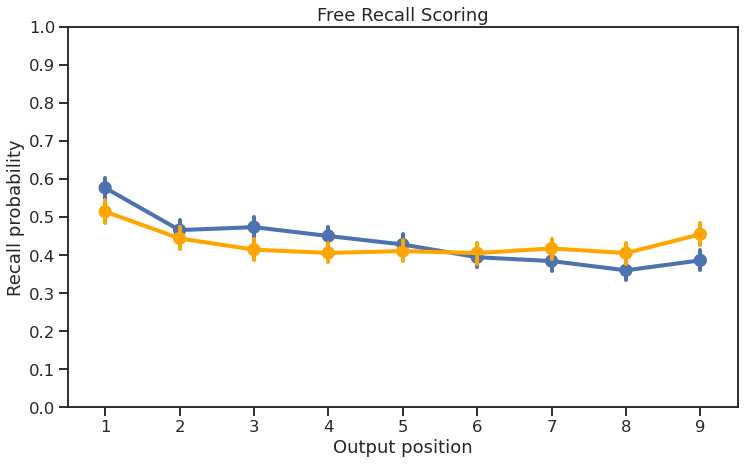

In [10]:
frfig = plt.figure(figsize = (12, 7))
ax1 = sns.pointplot(data=frfwd, x='x_values', y='probability', marker = 'o')
ax2 = sns.pointplot(data=frbwd, x='x_values', y='probability', marker = 'o', color = 'orange')
plt.xlabel('Output position')
plt.ylabel('Recall probability')
ax1.set_yticks([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
plt.title('Free Recall Scoring')
frfig.savefig("./../graphsE5/FinalSPC/frE2collapse.pdf", bbox_inches = 'tight',pad_inches = 0.2)

In [12]:
fbfr1 = stats.ttest_rel(statfr9[(statfr9.x_values == 1) & (statfr9.how == 'bwd')].probability, statfr9[(statfr9.x_values == 1) & (statfr9.how == 'fwd')].probability)[1]
fbfr2 = stats.ttest_rel(statfr9[(statfr9.x_values == 2) & (statfr9.how == 'bwd')].probability, statfr9[(statfr9.x_values == 2) & (statfr9.how == 'fwd')].probability)[1]
fbfr3 = stats.ttest_rel(statfr9[(statfr9.x_values == 3) & (statfr9.how == 'bwd')].probability, statfr9[(statfr9.x_values == 3) & (statfr9.how == 'fwd')].probability)[1]
fbfr4 = stats.ttest_rel(statfr9[(statfr9.x_values == 4) & (statfr9.how == 'bwd')].probability, statfr9[(statfr9.x_values == 4) & (statfr9.how == 'fwd')].probability)[1]
fbfr5 = stats.ttest_rel(statfr9[(statfr9.x_values == 5) & (statfr9.how == 'bwd')].probability, statfr9[(statfr9.x_values == 5) & (statfr9.how == 'fwd')].probability)[1]
fbfr6 = stats.ttest_rel(statfr9[(statfr9.x_values == 6) & (statfr9.how == 'bwd')].probability, statfr9[(statfr9.x_values == 6) & (statfr9.how == 'fwd')].probability)[1]
fbfr7 = stats.ttest_rel(statfr9[(statfr9.x_values == 7) & (statfr9.how == 'bwd')].probability, statfr9[(statfr9.x_values == 7) & (statfr9.how == 'fwd')].probability)[1]
fbfr8 = stats.ttest_rel(statfr9[(statfr9.x_values == 8) & (statfr9.how == 'bwd')].probability, statfr9[(statfr9.x_values == 8) & (statfr9.how == 'fwd')].probability)[1]
fbfr9 = stats.ttest_rel(statfr9[(statfr9.x_values == 9) & (statfr9.how == 'bwd')].probability, statfr9[(statfr9.x_values == 9) & (statfr9.how == 'fwd')].probability)[1]
fr_correct = [fbfr1,fbfr2,fbfr3,fbfr4,fbfr5,fbfr6,fbfr7,fbfr8,fbfr9]
print(sm.stats.multitest.fdrcorrection(fr_correct, alpha = 0.05))
print(sm.stats.multitest.fdrcorrection(fr_correct, alpha = 0.001))

(array([ True, False,  True,  True, False, False,  True,  True,  True]), array([3.48631342e-06, 7.86249845e-02, 1.12692382e-06, 2.94955285e-05,
       8.32251813e-02, 2.50742692e-01, 5.72351144e-03, 2.78425147e-04,
       1.15542208e-06]))
(array([ True, False,  True,  True, False, False, False,  True,  True]), array([3.48631342e-06, 7.86249845e-02, 1.12692382e-06, 2.94955285e-05,
       8.32251813e-02, 2.50742692e-01, 5.72351144e-03, 2.78425147e-04,
       1.15542208e-06]))


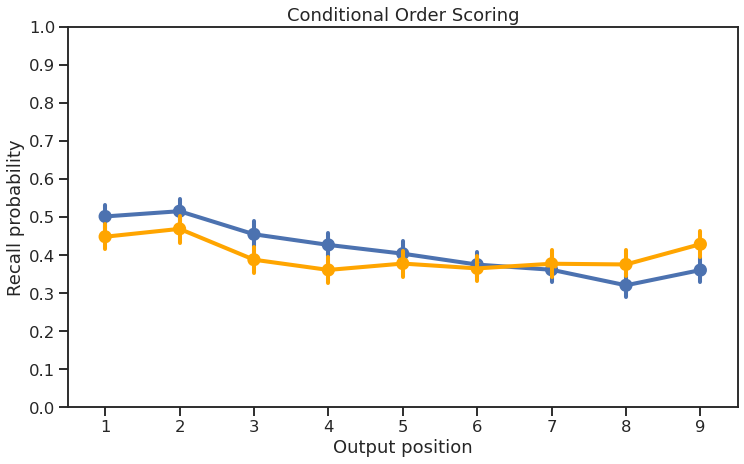

In [13]:
rosfig = plt.figure(figsize = (12, 7))
ax1 = sns.pointplot(data=rosfwd, x='x_values', y='probability', marker = 'o')
ax2 = sns.pointplot(data=rosbwd, x='x_values', y='probability', marker = 'o', color = 'orange')
plt.xlabel('Output position')
plt.ylabel('Recall probability')
ax1.set_yticks([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
plt.title('Conditional Order Scoring')
rosfig.savefig("./../graphsE5/FinalSPC/rosE2collapse.pdf", bbox_inches = 'tight',pad_inches = 0.2)

In [14]:
statros9 = pd.merge(rosfwd, rosbwd, how = 'left', left_on = ['subject','x_values'], right_on = ['subject', 'x_values'])
statros9.dropna(inplace = True)
fbros1 = stats.ttest_rel(statros9[(statros9.x_values == 1)].probability_x, statros9[(statros9.x_values == 1)].probability_y)[1]
fbros2 = stats.ttest_rel(statros9[(statros9.x_values == 2)].probability_x, statros9[(statros9.x_values == 2)].probability_y)[1]
fbros3 = stats.ttest_rel(statros9[(statros9.x_values == 3)].probability_x, statros9[(statros9.x_values == 3)].probability_y)[1]
fbros4 = stats.ttest_rel(statros9[(statros9.x_values == 4)].probability_x, statros9[(statros9.x_values == 4)].probability_y)[1]
fbros5 = stats.ttest_rel(statros9[(statros9.x_values == 5)].probability_x, statros9[(statros9.x_values == 5)].probability_y)[1]
fbros6 = stats.ttest_rel(statros9[(statros9.x_values == 6)].probability_x, statros9[(statros9.x_values == 6)].probability_y)[1]
fbros7 = stats.ttest_rel(statros9[(statros9.x_values == 7)].probability_x, statros9[(statros9.x_values == 7)].probability_y)[1]
fbros8 = stats.ttest_rel(statros9[(statros9.x_values == 8)].probability_x, statros9[(statros9.x_values == 8)].probability_y)[1]
fbros9 = stats.ttest_rel(statros9[(statros9.x_values == 9)].probability_x, statros9[(statros9.x_values == 9)].probability_y)[1]
ros_correct = [fbros1,fbros2,fbros3,fbros4,fbros5,fbros6,fbros7,fbros8,fbros9]
print(sm.stats.multitest.fdrcorrection(ros_correct, alpha = 0.05))
print(sm.stats.multitest.fdrcorrection(ros_correct, alpha = 0.001))

(array([ True,  True,  True,  True, False, False, False,  True,  True]), array([0.0016471 , 0.01010238, 0.01010238, 0.0016471 , 0.2104078 ,
       0.67241082, 0.67241082, 0.04381667, 0.00564223]))
(array([False, False, False, False, False, False, False, False, False]), array([0.0016471 , 0.01010238, 0.01010238, 0.0016471 , 0.2104078 ,
       0.67241082, 0.67241082, 0.04381667, 0.00564223]))


In [15]:
statsolway9.to_csv('./../graphsE5/Stat_CSVs/SPC_Stats')

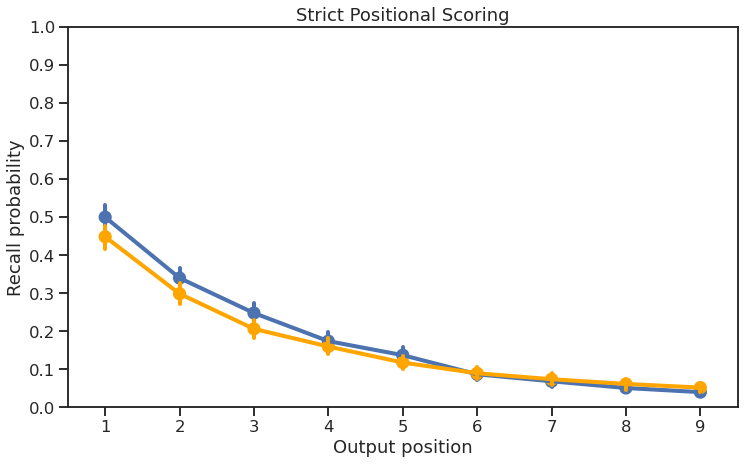

In [16]:
spsfig = plt.figure(figsize = (12, 7))
ax1 = sns.pointplot(data=spsfwd, x='x_values', y='probability', marker = 'o')
ax2 = sns.pointplot(data=spsbwd, x='x_values', y='probability', marker = 'o', color = 'orange')
plt.xlabel('Output position')
plt.ylabel('Recall probability')
ax1.set_yticks([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
plt.title('Strict Positional Scoring')
spsfig.savefig("./../graphsE5/FinalSPC/spsE2collapse.pdf", bbox_inches = 'tight',pad_inches = 0.2)

In [17]:
fbsps1 = stats.ttest_rel(statsps9[(statsps9.x_values == 1) & (statsps9.how == 'bwd')].probability, statsps9[(statsps9.x_values == 1) & (statsps9.how == 'fwd')].probability)[1]
fbsps2 = stats.ttest_rel(statsps9[(statsps9.x_values == 2) & (statsps9.how == 'bwd')].probability, statsps9[(statsps9.x_values == 2) & (statsps9.how == 'fwd')].probability)[1]
fbsps3 = stats.ttest_rel(statsps9[(statsps9.x_values == 3) & (statsps9.how == 'bwd')].probability, statsps9[(statsps9.x_values == 3) & (statsps9.how == 'fwd')].probability)[1]
fbsps4 = stats.ttest_rel(statsps9[(statsps9.x_values == 4) & (statsps9.how == 'bwd')].probability, statsps9[(statsps9.x_values == 4) & (statsps9.how == 'fwd')].probability)[1]
fbsps5 = stats.ttest_rel(statsps9[(statsps9.x_values == 5) & (statsps9.how == 'bwd')].probability, statsps9[(statsps9.x_values == 5) & (statsps9.how == 'fwd')].probability)[1]
fbsps6 = stats.ttest_rel(statsps9[(statsps9.x_values == 6) & (statsps9.how == 'bwd')].probability, statsps9[(statsps9.x_values == 6) & (statsps9.how == 'fwd')].probability)[1]
fbsps7 = stats.ttest_rel(statsps9[(statsps9.x_values == 7) & (statsps9.how == 'bwd')].probability, statsps9[(statsps9.x_values == 7) & (statsps9.how == 'fwd')].probability)[1]
fbsps8 = stats.ttest_rel(statsps9[(statsps9.x_values == 8) & (statsps9.how == 'bwd')].probability, statsps9[(statsps9.x_values == 8) & (statsps9.how == 'fwd')].probability)[1]
fbsps9 = stats.ttest_rel(statsps9[(statsps9.x_values == 9) & (statsps9.how == 'bwd')].probability, statsps9[(statsps9.x_values == 9) & (statsps9.how == 'fwd')].probability)[1]
sps_correct = [fbsps1,fbsps2,fbsps3,fbsps4,fbsps5,fbsps6,fbsps7,fbsps8,fbsps9]
print(sm.stats.multitest.fdrcorrection(sps_correct, alpha = 0.05))
print(sm.stats.multitest.fdrcorrection(sps_correct, alpha = 0.001))

(array([ True,  True,  True, False,  True, False, False,  True,  True]), array([0.00184146, 0.00284674, 0.00184146, 0.1597285 , 0.00500744,
       0.62515249, 0.33233318, 0.01796272, 0.00462852]))
(array([False, False, False, False, False, False, False, False, False]), array([0.00184146, 0.00284674, 0.00184146, 0.1597285 , 0.00500744,
       0.62515249, 0.33233318, 0.01796272, 0.00462852]))


## Recall Initiation

In [5]:
pfr9fwd = pfr(subs, 9, how = 'fwd')
pfr9bwd_flip = pfr(subs, 9, how = 'bwd', flip_bwd = True)

In [6]:
pfr_stat9 = pd.merge(pfr9fwd, pfr9bwd_flip, how = 'left', left_on = ['subject','x_values'], right_on = ['subject', 'x_values'])
pfr_stat9.dropna(inplace = True)

In [159]:
pfr1 = stats.ttest_rel(pfr_stat9[(pfr_stat9.x_values == 1)].probability_x, pfr_stat9[(pfr_stat9.x_values == 1)].probability_y)[1]
pfr2 = stats.ttest_rel(pfr_stat9[(pfr_stat9.x_values == 2)].probability_x, pfr_stat9[(pfr_stat9.x_values == 2)].probability_y)[1]
pfr3 = stats.ttest_rel(pfr_stat9[(pfr_stat9.x_values == 3)].probability_x, pfr_stat9[(pfr_stat9.x_values == 3)].probability_y)[1]
pfr4 = stats.ttest_rel(pfr_stat9[(pfr_stat9.x_values == 4)].probability_x, pfr_stat9[(pfr_stat9.x_values == 4)].probability_y)[1]
pfr5 = stats.ttest_rel(pfr_stat9[(pfr_stat9.x_values == 5)].probability_x, pfr_stat9[(pfr_stat9.x_values == 5)].probability_y)[1]
pfr6 = stats.ttest_rel(pfr_stat9[(pfr_stat9.x_values == 6)].probability_x, pfr_stat9[(pfr_stat9.x_values == 6)].probability_y)[1]
pfr7 = stats.ttest_rel(pfr_stat9[(pfr_stat9.x_values == 7)].probability_x, pfr_stat9[(pfr_stat9.x_values == 7)].probability_y)[1]
pfr8 = stats.ttest_rel(pfr_stat9[(pfr_stat9.x_values == 8)].probability_x, pfr_stat9[(pfr_stat9.x_values == 8)].probability_y)[1]
pfr9 = stats.ttest_rel(pfr_stat9[(pfr_stat9.x_values == 9)].probability_x, pfr_stat9[(pfr_stat9.x_values == 9)].probability_y)[1]
pfr_correct = [pfr1,pfr2,pfr3,pfr4,pfr5,pfr6,pfr7,pfr8,pfr9]
print(sm.stats.multitest.fdrcorrection(pfr_correct, alpha = 0.05))
print(sm.stats.multitest.fdrcorrection(pfr_correct, alpha = 0.001))

(array([ True,  True, False, False, False, False, False, False, False]), array([1.11914449e-03, 5.63129228e-04, 1.68542659e-01, 3.46066575e-01,
       1.38158168e-01, 4.99090655e-01, 8.34354422e-01, 8.34354422e-01,
       6.59042713e-01]))
(array([False,  True, False, False, False, False, False, False, False]), array([1.11914449e-03, 5.63129228e-04, 1.68542659e-01, 3.46066575e-01,
       1.38158168e-01, 4.99090655e-01, 8.34354422e-01, 8.34354422e-01,
       6.59042713e-01]))


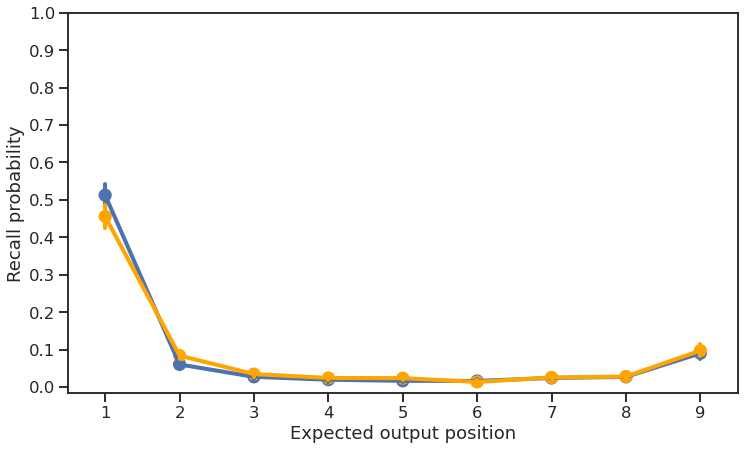

In [38]:
pfr_op = plt.figure(figsize = (12, 7))
ax1 = sns.pointplot(data=pfr9fwd, x='x_values', y='probability', marker = 'o')
ax2 = sns.pointplot(data=pfr9bwd_flip, x='x_values', y='probability', marker = 'o', color = 'orange')
plt.xlabel('Expected output position')
plt.ylabel('Recall probability')
ax1.set_yticks([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
pfr_op.savefig("./../graphsE5/pfr_op.pdf", bbox_inches = 'tight',pad_inches = 0.2)

In [7]:
pfr9fwd_start = pfr9fwd.query('x_values == 1')
pfr9bwd_flip_start = pfr9bwd_flip.query('x_values == 1')

pfr9fwd_start.dropna(inplace = True)
pfr9bwd_flip_start.dropna(inplace = True)

pfr9fwd_start = pfr9fwd_start.query('subject in @pfr9bwd_flip_start.subject.values')
pfr9bwd_flip_start = pfr9bwd_flip_start.query('subject in @pfr9fwd_start.subject.values')

print(stats.ttest_rel(pfr9fwd_start.probability, pfr9bwd_flip_start.probability))

Ttest_relResult(statistic=3.687798601764647, pvalue=0.00024869877643224613)


<ipython-input-7-293b5ff2f871>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pfr9fwd_start.dropna(inplace = True)
<ipython-input-7-293b5ff2f871>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pfr9bwd_flip_start.dropna(inplace = True)


In [8]:
pfr9fwd.dropna(inplace = True)
pfr9bwd_flip.dropna(inplace = True)
pfr9fwd = pfr9fwd.query('subject in @pfr9bwd_flip.subject.values')
pfr9bwd_flip = pfr9bwd_flip.query('subject in @pfr9fwd.subject.values')

In [9]:
len(pfr9fwd.subject.unique())

550

In [41]:
statpfr9cue = pd.concat([pfr9fwd, pfr9bwd_flip])
statpfr9cue.sort_values('subject', inplace = True)
statpfr9cue.to_csv('./../graphsE5/Stat_CSVs/PFR_Stats')

## Recall Transitions

### Graphs

In [42]:
crp6fwd = lagCRP_curve(subs, 6, how = 'fwd')
crp6bwd = lagCRP_curve(subs, 6, how = 'bwd')

crp7fwd = lagCRP_curve(subs, 7, how = 'fwd')
crp7bwd = lagCRP_curve(subs, 7, how = 'bwd')

crp8fwd = lagCRP_curve(subs, 8, how = 'fwd')
crp8bwd = lagCRP_curve(subs, 8, how = 'bwd')

crp9fwd = lagCRP_curve(subs, 9, how = 'fwd')
crp9bwd = lagCRP_curve(subs, 9, how = 'bwd')

crp10fwd = lagCRP_curve(subs, 10, how = 'fwd')
crp10bwd = lagCRP_curve(subs, 10, how = 'bwd')

crp11fwd = lagCRP_curve(subs, 11, how = 'fwd')
crp11bwd = lagCRP_curve(subs, 11, how = 'bwd')

crp12fwd = lagCRP_curve(subs, 12, how = 'fwd')
crp12bwd = lagCRP_curve(subs, 12, how = 'bwd')

In [43]:
crp6fwd = crp_nan_remover(crp6fwd)
crp6bwd = crp_nan_remover(crp6bwd)

crp6fwd = crp6fwd.query('subject in @crp6bwd.subject.values')
crp6bwd = crp6bwd.query('subject in @crp6fwd.subject.values')

In [44]:
crp7fwd = crp_nan_remover(crp7fwd)
crp7bwd = crp_nan_remover(crp7bwd)

crp7fwd = crp7fwd.query('subject in @crp7bwd.subject.values')
crp7bwd = crp7bwd.query('subject in @crp7fwd.subject.values')

In [45]:
crp8fwd = crp_nan_remover(crp8fwd)
crp8bwd = crp_nan_remover(crp8bwd)

crp8fwd = crp8fwd.query('subject in @crp8bwd.subject.values')
crp8bwd = crp8bwd.query('subject in @crp8fwd.subject.values')

In [46]:
crp9fwd = crp_nan_remover(crp9fwd)
crp9bwd = crp_nan_remover(crp9bwd)

crp9fwd = crp9fwd.query('subject in @crp9bwd.subject.values')
crp9bwd = crp9bwd.query('subject in @crp9fwd.subject.values')

In [47]:
crp10fwd = crp_nan_remover(crp10fwd)
crp10bwd = crp_nan_remover(crp10bwd)

crp10fwd = crp10fwd.query('subject in @crp10bwd.subject.values')
crp10bwd = crp10bwd.query('subject in @crp10fwd.subject.values')

In [48]:
crp11fwd = crp_nan_remover(crp11fwd)
crp11bwd = crp_nan_remover(crp11bwd)

crp11fwd = crp11fwd.query('subject in @crp11bwd.subject.values')
crp11bwd = crp11bwd.query('subject in @crp11fwd.subject.values')

In [49]:
crp12fwd = crp_nan_remover(crp12fwd)
crp12bwd = crp_nan_remover(crp12bwd)

crp12fwd = crp12fwd.query('subject in @crp12bwd.subject.values')
crp12bwd = crp12bwd.query('subject in @crp12fwd.subject.values')

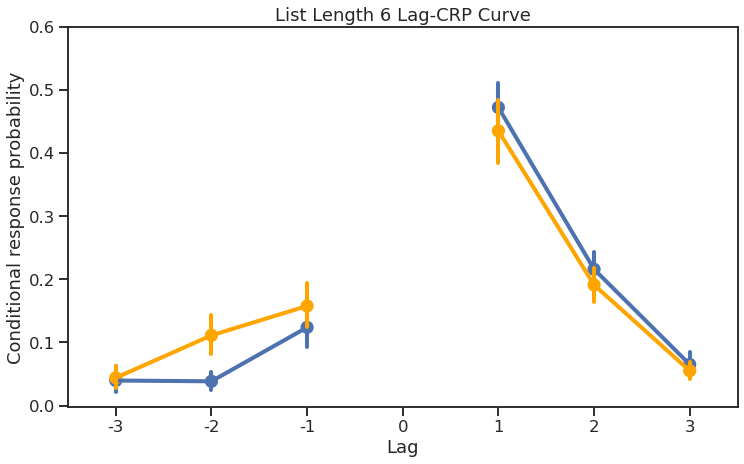

In [50]:
crp6fig= plt.figure(figsize = (12, 7))
ax1 = sns.pointplot(data=crp6fwd, x='x_values', y='probability', marker = 'o')
ax2 = sns.pointplot(data=crp6bwd, x='x_values', y='probability', marker = 'o', color = 'orange')
plt.xlabel('Lag')
plt.ylabel('Conditional response probability')
ax1.set_yticks([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6])
plt.title('List Length 6 Lag-CRP Curve')
crp6fig.savefig("./../graphsE5/E2CRP6.pdf", bbox_inches = 'tight',pad_inches = 0.2)

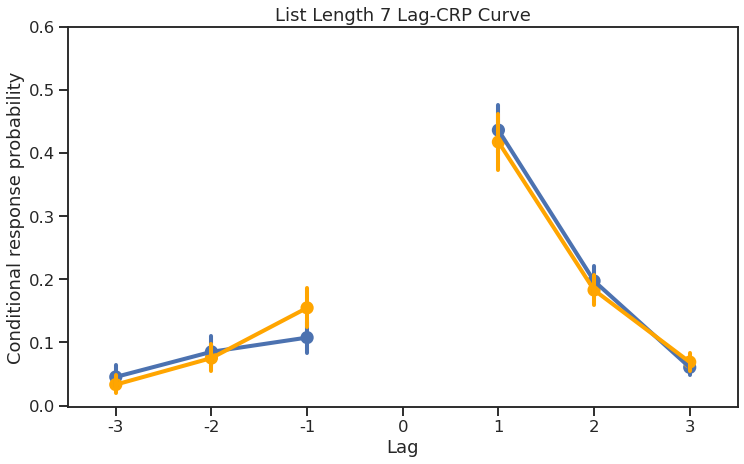

In [51]:
crp7fig= plt.figure(figsize = (12, 7))
ax1 = sns.pointplot(data=crp7fwd, x='x_values', y='probability', marker = 'o')
ax2 = sns.pointplot(data=crp7bwd, x='x_values', y='probability', marker = 'o', color = 'orange')
plt.xlabel('Lag')
plt.ylabel('Conditional response probability')
ax1.set_yticks([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6])
plt.title('List Length 7 Lag-CRP Curve')
crp7fig.savefig("./../graphsE5/E2CRP7.pdf", bbox_inches = 'tight',pad_inches = 0.2)

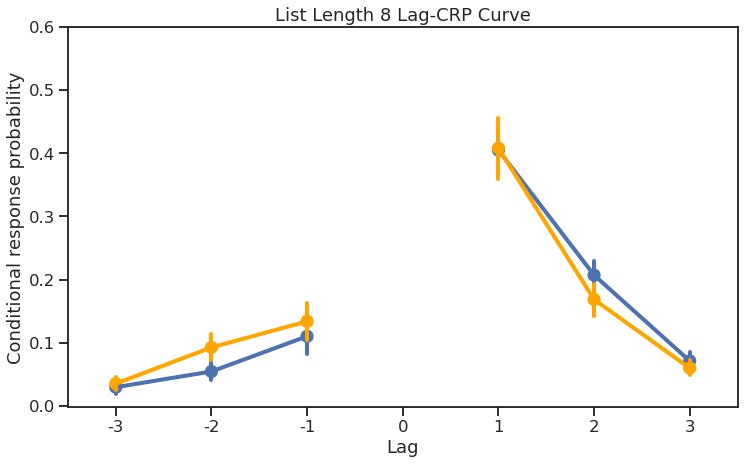

In [52]:
crp8fig= plt.figure(figsize = (12, 7))
ax1 = sns.pointplot(data=crp8fwd, x='x_values', y='probability', marker = 'o')
ax2 = sns.pointplot(data=crp8bwd, x='x_values', y='probability', marker = 'o', color = 'orange')
plt.xlabel('Lag')
plt.ylabel('Conditional response probability')
ax1.set_yticks([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6])
plt.title('List Length 8 Lag-CRP Curve')
crp8fig.savefig("./../graphsE5/E2CRP8.pdf", bbox_inches = 'tight',pad_inches = 0.2)

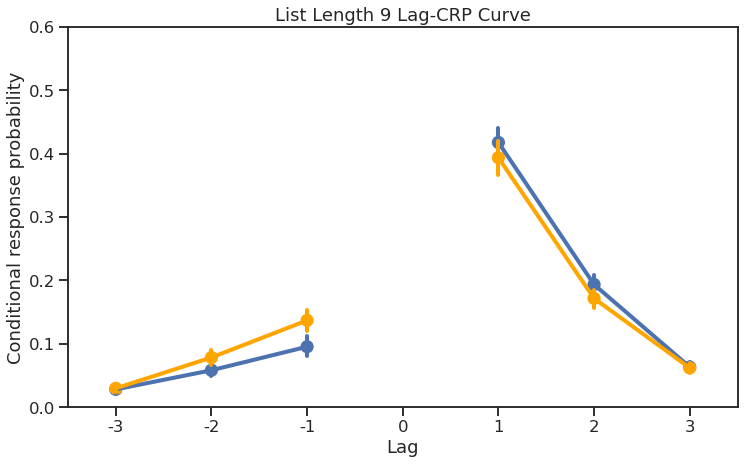

In [53]:
crp9fig= plt.figure(figsize = (12, 7))
ax1 = sns.pointplot(data=crp9fwd, x='x_values', y='probability', marker = 'o')
ax2 = sns.pointplot(data=crp9bwd, x='x_values', y='probability', marker = 'o', color = 'orange')
plt.xlabel('Lag')
plt.ylabel('Conditional response probability')
ax1.set_yticks([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6])
plt.title('List Length 9 Lag-CRP Curve')
crp9fig.savefig("./../graphsE5/E2CRP.pdf", bbox_inches = 'tight',pad_inches = 0.2)

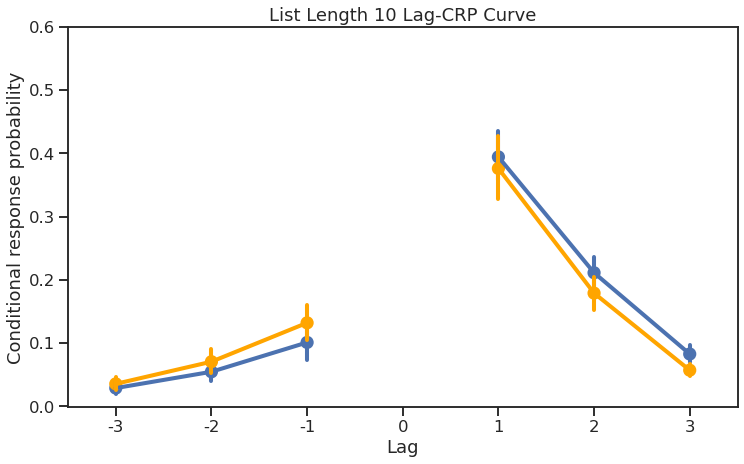

In [54]:
crp10fig= plt.figure(figsize = (12, 7))
ax1 = sns.pointplot(data=crp10fwd, x='x_values', y='probability', marker = 'o')
ax2 = sns.pointplot(data=crp10bwd, x='x_values', y='probability', marker = 'o', color = 'orange')
plt.xlabel('Lag')
plt.ylabel('Conditional response probability')
ax1.set_yticks([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6])
plt.title('List Length 10 Lag-CRP Curve')
crp10fig.savefig("./../graphsE5/E2CRP10.pdf", bbox_inches = 'tight',pad_inches = 0.2)

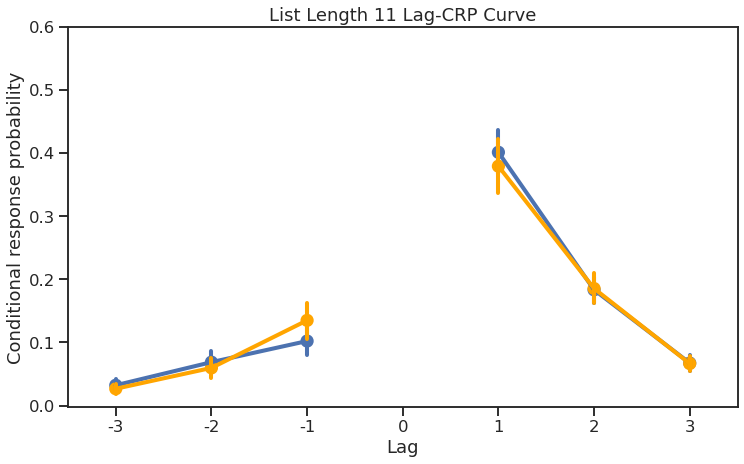

In [55]:
crp11fig= plt.figure(figsize = (12, 7))
ax1 = sns.pointplot(data=crp11fwd, x='x_values', y='probability', marker = 'o')
ax2 = sns.pointplot(data=crp11bwd, x='x_values', y='probability', marker = 'o', color = 'orange')
plt.xlabel('Lag')
plt.ylabel('Conditional response probability')
ax1.set_yticks([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6])
plt.title('List Length 11 Lag-CRP Curve')
crp11fig.savefig("./../graphsE5/E2CRP11.pdf", bbox_inches = 'tight',pad_inches = 0.2)

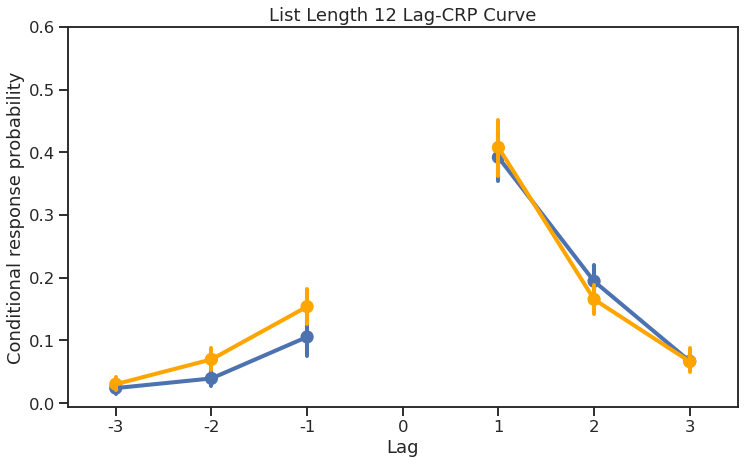

In [56]:
crp12fig= plt.figure(figsize = (12, 7))
ax1 = sns.pointplot(data=crp12fwd, x='x_values', y='probability', marker = 'o')
ax2 = sns.pointplot(data=crp12bwd, x='x_values', y='probability', marker = 'o', color = 'orange')
plt.xlabel('Lag')
plt.ylabel('Conditional response probability')
ax1.set_yticks([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6])
plt.title('List Length 12 Lag-CRP Curve')
crp12fig.savefig("./../graphsE5/E2CRP12.pdf", bbox_inches = 'tight',pad_inches = 0.2)

In [57]:
foejump1crp9fwd = foelagCRP_curve(subs, 9, how = 'fwd', jump = 2)
foejump1crp9bwd = foelagCRP_curve(subs, 9, how = 'bwd', jump = 2)

foejump1crp9fwd = foejump1crp9fwd[(foejump1crp9fwd.x_values != -3) & (foejump1crp9fwd.x_values != -2)]
foejump1crp9bwd = foejump1crp9bwd[(foejump1crp9bwd.x_values != -3) & (foejump1crp9bwd.x_values != -2)]


In [58]:
foejump1crp9fwd = crp_nan_remover(foejump1crp9fwd)
foejump1crp9bwd = crp_nan_remover(foejump1crp9bwd)

foejump1crp9fwd = foejump1crp9fwd.query('subject in @foejump1crp9bwd.subject.values')
foejump1crp9bwd = foejump1crp9bwd.query('subject in @foejump1crp9fwd.subject.values')

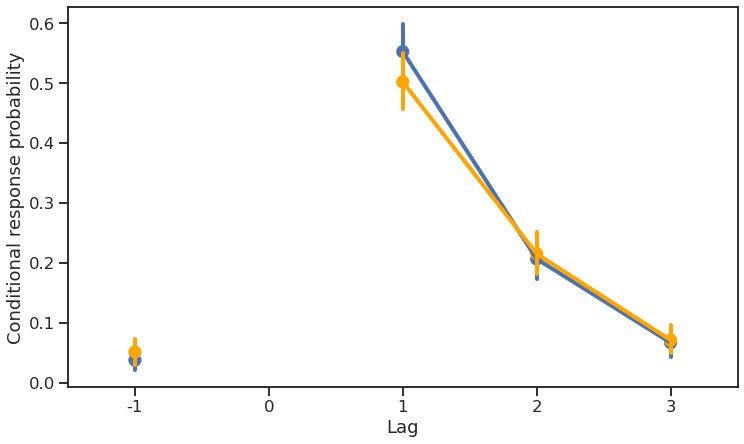

In [59]:
foejump1crp9fwdcuefig= plt.figure(figsize = (12, 7))
ax1 = sns.pointplot(data=foejump1crp9fwd, x='x_values', y='probability', marker = 'o')
ax2 = sns.pointplot(data=foejump1crp9bwd, x='x_values', y='probability', marker = 'o', color = 'orange')
plt.xlabel('Lag')
plt.ylabel('Conditional response probability')
ax1.set_yticks([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6])
foejump1crp9fwdcuefig.savefig("./../graphsE5/E1Jump1.pdf", bbox_inches = 'tight',pad_inches = 0.2)

### Statistical Tests

In [60]:
crp9fwd_pos1 = lagCRP_curve(subs, 9, how = 'fwd').query('x_values == 1')
crp9bwd_pos1 = lagCRP_curve(subs, 9, how = 'bwd').query('x_values == 1')

crp9fwd_pos1.dropna(inplace = True)
crp9bwd_pos1.dropna(inplace = True)

crp9fwd_pos1 = crp9fwd_pos1.query('subject in @crp9bwd_pos1.subject.unique()')
crp9bwd_pos1 = crp9bwd_pos1.query('subject in @crp9fwd_pos1.subject.unique()')

stats.ttest_rel(crp9fwd_pos1.probability, crp9bwd_pos1.probability)

Ttest_relResult(statistic=2.4851589042273186, pvalue=0.013293219268060227)

In [61]:
print(len(crp9bwd_pos1.subject.unique()))

475


In [62]:
crp9fwd_neg1 = lagCRP_curve(subs, 9, how = 'fwd').query('x_values == -1')
crp9bwd_neg1 = lagCRP_curve(subs, 9, how = 'bwd').query('x_values == -1')

crp9fwd_neg1.dropna(inplace = True)
crp9bwd_neg1.dropna(inplace = True)

crp9fwd_neg1 = crp9fwd_neg1.query('subject in @crp9bwd_neg1.subject.unique()')
crp9bwd_neg1 = crp9bwd_neg1.query('subject in @crp9fwd_neg1.subject.unique()')

stats.ttest_rel(crp9fwd_neg1.probability, crp9bwd_neg1.probability)

Ttest_relResult(statistic=-3.498989765593499, pvalue=0.0005122651699703856)

In [63]:
print(len(crp9bwd_neg1.subject.unique()))

463


In [64]:
foecrp9fwd_neg1 = foelagCRP_curve(subs, 9, how = 'fwd', jump = 2).query('x_values == -1')
foecrp9bwd_neg1 = foelagCRP_curve(subs, 9, how = 'bwd', jump = 2).query('x_values == -1')

foecrp9fwd_neg1.dropna(inplace = True)
foecrp9bwd_neg1.dropna(inplace = True)

foecrp9fwd_neg1 = foecrp9fwd_neg1.query('subject in @foecrp9bwd_neg1.subject.unique()')
foecrp9bwd_neg1 = foecrp9bwd_neg1.query('subject in @foecrp9fwd_neg1.subject.unique()')

stats.ttest_rel(foecrp9fwd_neg1.probability, foecrp9bwd_neg1.probability)

Ttest_relResult(statistic=-1.1916689588763858, pvalue=0.23456326092832988)

In [65]:
print(len(foecrp9bwd_neg1.subject.unique()))

242


In [66]:
foecrp9fwd_over1 = pos_outcomes_foeCRP(subs, 9, how = 'fwd', jump = 2).query('x_values == 1')
foecrp9bwd_over1 = pos_outcomes_foeCRP(subs, 9, how = 'bwd', jump = 2).query('x_values == 1')

foecrp9fwd_over1.dropna(inplace = True)
foecrp9bwd_over1.dropna(inplace = True)

foecrp9fwd_over1 = foecrp9fwd_over1.query('subject in @foecrp9bwd_over1.subject.unique()')
foecrp9bwd_over1 = foecrp9bwd_over1.query('subject in @foecrp9fwd_over1.subject.unique()')

stats.ttest_rel(foecrp9fwd_over1.probability, foecrp9bwd_over1.probability)

Ttest_relResult(statistic=1.2470291842840506, pvalue=0.21360237649663597)

In [67]:
len(foecrp9fwd_over1.subject.unique())

241

In [68]:
foecrp9fwd_pos1 = foelagCRP_curve(subs, 9, how = 'fwd', jump = 2).query('x_values == 1')
foecrp9bwd_pos1 = foelagCRP_curve(subs, 9, how = 'bwd', jump = 2).query('x_values == 1')

foecrp9fwd_pos1.dropna(inplace = True)
foecrp9bwd_pos1.dropna(inplace = True)

foecrp9fwd_pos1 = foecrp9fwd_pos1.query('subject in @foecrp9bwd_pos1.subject.unique()')
foecrp9bwd_pos1 = foecrp9bwd_pos1.query('subject in @foecrp9fwd_pos1.subject.unique()')

stats.ttest_rel(foecrp9fwd_pos1.probability, foecrp9bwd_pos1.probability)

Ttest_relResult(statistic=1.7658125672573275, pvalue=0.07869874405002149)

In [69]:
print(len(foecrp9bwd_pos1.subject.unique()))

241


In [70]:
foecrp9fwd_over1_inc = pos_outcomes_foeCRP(subs, 9, how = 'fwd', jump = 2, exclude_correct = True).query('x_values == 1')
foecrp9bwd_over1_inc = pos_outcomes_foeCRP(subs, 9, how = 'bwd', jump = 2, exclude_correct = True).query('x_values == 1')

foecrp9fwd_over1_inc.dropna(inplace = True)
foecrp9bwd_over1_inc.dropna(inplace = True)

foecrp9fwd_over1_inc = foecrp9fwd_over1_inc.query('subject in @foecrp9bwd_over1_inc.subject.unique()')
foecrp9bwd_over1_inc = foecrp9bwd_over1_inc.query('subject in @foecrp9fwd_over1_inc.subject.unique()')

stats.ttest_rel(foecrp9fwd_over1_inc.probability, foecrp9bwd_over1_inc.probability)

Ttest_relResult(statistic=-0.9882692399783165, pvalue=0.32402444653176843)

In [71]:
len(foecrp9bwd_over1_inc.subject.unique())

239

In [72]:
crp9fwd_neg1 = crp9fwd.query('x_values == -1')
crp9bwd_neg1 = crp9bwd.query('x_values == -1')

In [73]:
crp9fwd_neg1.dropna(inplace = True)
crp9bwd_neg1.dropna(inplace = True)

crp9fwd_neg1 = crp9fwd_neg1.query('subject in @crp9bwd_neg1.subject.values')
crp9bwd_neg1 = crp9bwd_neg1.query('subject in @crp9fwd_neg1.subject.values')

onelagcrp9cue = pd.concat([crp9fwd_neg1, crp9bwd_neg1])
onelagcrp9cue.sort_values('subject', inplace = True)
onelagcrp9cue.to_csv('./../graphsE5/Stat_CSVs/Lag_NegOne_Cue')

In [74]:
crp9fwd_pos1 = crp9fwd.query('x_values == 1')
crp9bwd_pos1 = crp9bwd.query('x_values == 1')

In [75]:
crp9fwd_pos1.dropna(inplace = True)
crp9bwd_pos1.dropna(inplace = True)

crp9fwd_pos1 = crp9fwd_pos1.query('subject in @crp9bwd_pos1.subject.values')
crp9bwd_pos1 = crp9bwd_pos1.query('subject in @crp9fwd_pos1.subject.values')

onelagcrp9cue = pd.concat([crp9fwd_pos1, crp9bwd_pos1])
onelagcrp9cue.sort_values('subject', inplace = True)
onelagcrp9cue.to_csv('./../graphsE5/Stat_CSVs/Lag_PosOne_Cue')

In [76]:
foecrp9fwd_neg1 = foejump1crp9fwd.query('x_values == -1')
foecrp9bwd_neg1 = foejump1crp9bwd.query('x_values == -1')

In [77]:
foecrp9fwd_neg1.dropna(inplace = True)
foecrp9bwd_neg1.dropna(inplace = True)

foecrp9fwd_neg1 = foecrp9fwd_neg1.query('subject in @foecrp9bwd_neg1.subject.values')
foecrp9bwd_neg1 = foecrp9bwd_neg1.query('subject in @foecrp9fwd_neg1.subject.values')

onelagfoecrp9cue = pd.concat([foecrp9fwd_neg1, foecrp9bwd_neg1])
onelagfoecrp9cue.sort_values('subject', inplace = True)
onelagfoecrp9cue.to_csv('./../graphsE5/Stat_CSVs/FOE_Lag_NegOne_Cue')

### Expected Output Position Analyses

In [162]:
fwd_sp = serposCRP(subs, 9, how = 'fwd')
bwd_sp = serposCRP(subs, 9, how = 'bwd')

In [163]:
fwd_sp1 = fwd_sp.query('serpos == 1')
bwd_sp1 = bwd_sp.query('serpos == 9')

fwd_sp2 = fwd_sp.query('serpos == 2')
bwd_sp2 = bwd_sp.query('serpos == 8')

fwd_sp3 = fwd_sp.query('serpos == 3')
bwd_sp3 = bwd_sp.query('serpos == 7')

fwd_sp4 = fwd_sp.query('serpos == 4')
bwd_sp4 = bwd_sp.query('serpos == 6')

fwd_sp5 = fwd_sp.query('serpos == 5')
bwd_sp5 = bwd_sp.query('serpos == 5')

fwd_sp6 = fwd_sp.query('serpos == 6')
bwd_sp6 = bwd_sp.query('serpos == 4')

fwd_sp7 = fwd_sp.query('serpos == 7')
bwd_sp7 = bwd_sp.query('serpos == 3')

fwd_sp8 = fwd_sp.query('serpos == 8')
bwd_sp8 = bwd_sp.query('serpos == 2')

fwd_sp9 = fwd_sp.query('serpos == 9')
bwd_sp9 = bwd_sp.query('serpos == 1')

In [164]:
fwd_sp2 = eop_nan_remover(fwd_sp2)
bwd_sp2 = eop_nan_remover(bwd_sp2)

fwd_sp2 = fwd_sp2.query('subject in @bwd_sp2.subject.values')
bwd_sp2 = bwd_sp2.query('subject in @fwd_sp2.subject.values')
fwd_sp2 = fwd_sp2.query('subject in @bwd_sp2.subject.values')

In [165]:
fwd_sp3 = eop_nan_remover(fwd_sp3)
bwd_sp3 = eop_nan_remover(bwd_sp3)

fwd_sp3 = fwd_sp3.query('subject in @bwd_sp3.subject.values')
bwd_sp3 = bwd_sp3.query('subject in @fwd_sp3.subject.values')
fwd_sp3 = fwd_sp3.query('subject in @bwd_sp3.subject.values')

In [166]:
fwd_sp4 = eop_nan_remover(fwd_sp4)
bwd_sp4 = eop_nan_remover(bwd_sp4)

fwd_sp4 = fwd_sp4.query('subject in @bwd_sp4.subject.values')
bwd_sp4 = bwd_sp4.query('subject in @fwd_sp4.subject.values')
fwd_sp4 = fwd_sp4.query('subject in @bwd_sp4.subject.values')

In [167]:
fwd_sp5 = eop_nan_remover(fwd_sp5)
bwd_sp5 = eop_nan_remover(bwd_sp5)

fwd_sp5 = fwd_sp5.query('subject in @bwd_sp5.subject.values')
bwd_sp5 = bwd_sp5.query('subject in @fwd_sp5.subject.values')
fwd_sp5 = fwd_sp5.query('subject in @bwd_sp5.subject.values')

In [168]:
fwd_sp6 = eop_nan_remover(fwd_sp6)
bwd_sp6 = eop_nan_remover(bwd_sp6)

fwd_sp6 = fwd_sp6.query('subject in @bwd_sp6.subject.values')
bwd_sp6 = bwd_sp6.query('subject in @fwd_sp6.subject.values')
fwd_sp6 = fwd_sp6.query('subject in @bwd_sp6.subject.values')

In [169]:
fwd_sp7 = eop_nan_remover(fwd_sp7)
bwd_sp7 = eop_nan_remover(bwd_sp7)

fwd_sp7 = fwd_sp7.query('subject in @bwd_sp7.subject.values')
bwd_sp7 = bwd_sp7.query('subject in @fwd_sp7.subject.values')
fwd_sp7 = fwd_sp7.query('subject in @bwd_sp7.subject.values')

In [170]:
fwd_sp8 = eop_nan_remover(fwd_sp8)
bwd_sp8 = eop_nan_remover(bwd_sp8)

fwd_sp8 = fwd_sp8.query('subject in @bwd_sp8.subject.values')
bwd_sp8 = bwd_sp8.query('subject in @fwd_sp8.subject.values')
fwd_sp8 = fwd_sp8.query('subject in @bwd_sp8.subject.values')

In [171]:
fwd_sp9 = eop_nan_remover(fwd_sp9)
bwd_sp9 = eop_nan_remover(bwd_sp9)

fwd_sp9 = fwd_sp9.query('subject in @bwd_sp9.subject.values')
bwd_sp9 = bwd_sp9.query('subject in @fwd_sp9.subject.values')
fwd_sp9 = fwd_sp9.query('subject in @bwd_sp9.subject.values')

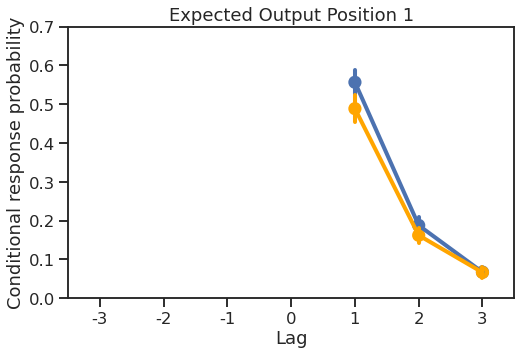

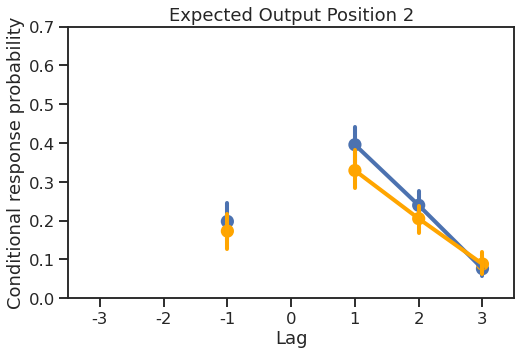

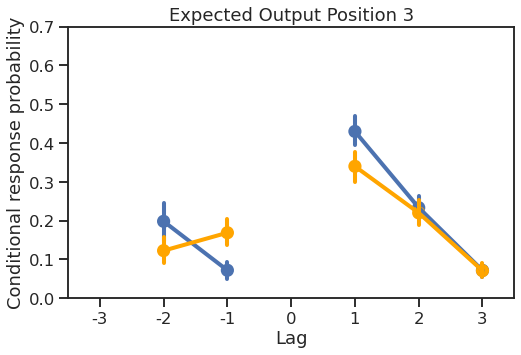

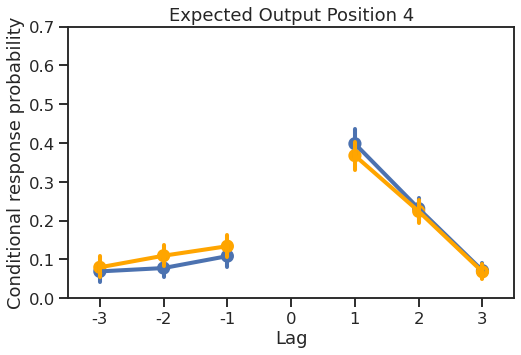

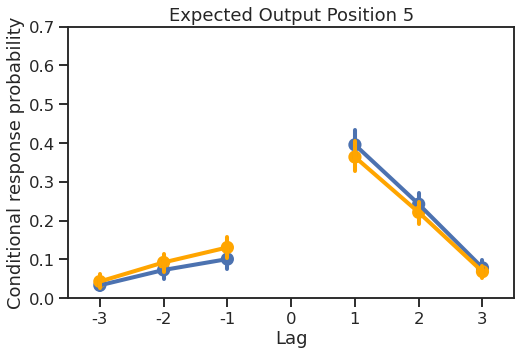

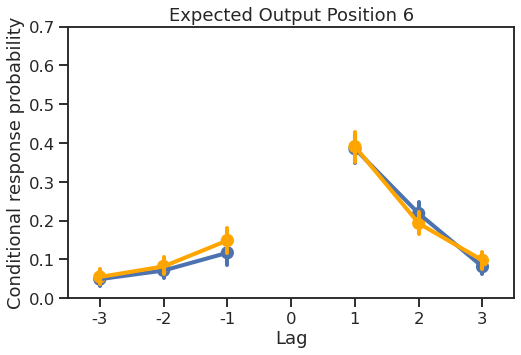

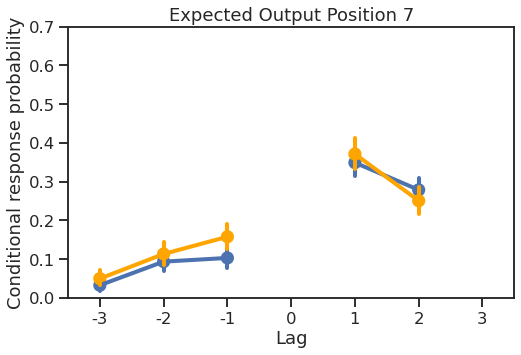

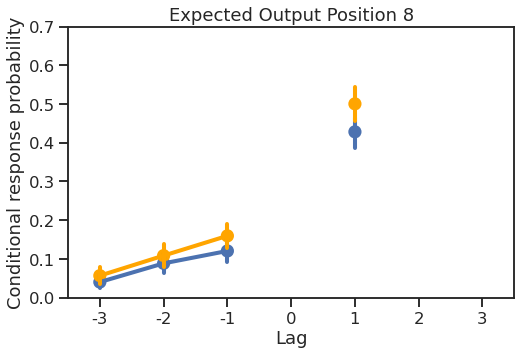

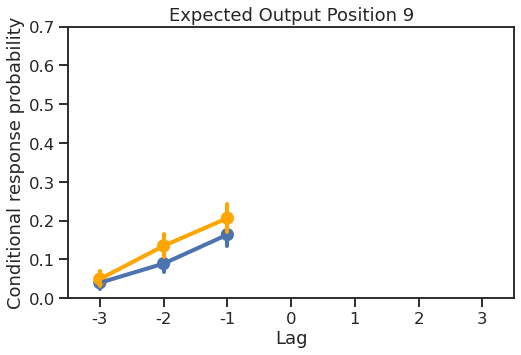

In [172]:
serposCRP1 = plt.figure(figsize = (8, 5))
ax1 = sns.pointplot(data=fwd_sp1, x='lag', y='probability', marker = 'o')
ax2 = sns.pointplot(data=bwd_sp1, x='lag', y='probability', marker = 'o', color = 'orange')
plt.xlabel('Lag')
plt.ylabel('Conditional response probability')
ax1.set_yticks([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7])
plt.title("Expected Output Position 1")
serposCRP1.savefig("./../graphsE5/EOS_CRPs/E1_EOS1.pdf", bbox_inches = 'tight',pad_inches = 0.2)

serposCRP2 = plt.figure(figsize = (8, 5))
ax1 = sns.pointplot(data=fwd_sp2, x='lag', y='probability', marker = 'o')
ax2 = sns.pointplot(data=bwd_sp2, x='lag', y='probability', marker = 'o', color = 'orange')
plt.xlabel('Lag')
plt.ylabel('Conditional response probability')
ax1.set_yticks([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7])
plt.title("Expected Output Position 2")
serposCRP2.savefig("./../graphsE5/EOS_CRPs/E2_EOS2.pdf", bbox_inches = 'tight',pad_inches = 0.2)

serposCRP3 = plt.figure(figsize = (8, 5))
ax1 = sns.pointplot(data=fwd_sp3, x='lag', y='probability', marker = 'o')
ax2 = sns.pointplot(data=bwd_sp3, x='lag', y='probability', marker = 'o', color = 'orange')
plt.xlabel('Lag')
plt.ylabel('Conditional response probability')
ax1.set_yticks([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7])
plt.title("Expected Output Position 3")
serposCRP3.savefig("./../graphsE5/EOS_CRPs/E2_EOS3.pdf", bbox_inches = 'tight',pad_inches = 0.2)

serposCRP4 = plt.figure(figsize = (8, 5))
ax1 = sns.pointplot(data=fwd_sp4, x='lag', y='probability', marker = 'o')
ax2 = sns.pointplot(data=bwd_sp4, x='lag', y='probability', marker = 'o', color = 'orange')
plt.xlabel('Lag')
plt.ylabel('Conditional response probability')
ax1.set_yticks([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7])
plt.title("Expected Output Position 4")
serposCRP4.savefig("./../graphsE5/EOS_CRPs/E2_EOS4.pdf", bbox_inches = 'tight',pad_inches = 0.2)

serposCRP5 = plt.figure(figsize = (8, 5))
ax1 = sns.pointplot(data=fwd_sp5, x='lag', y='probability', marker = 'o')
ax2 = sns.pointplot(data=bwd_sp5, x='lag', y='probability', marker = 'o', color = 'orange')
plt.xlabel('Lag')
plt.ylabel('Conditional response probability')
ax1.set_yticks([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7])
plt.title("Expected Output Position 5")
serposCRP5.savefig("./../graphsE5/EOS_CRPs/E2_EOS5.pdf", bbox_inches = 'tight',pad_inches = 0.2)

serposCRP6 = plt.figure(figsize = (8, 5))
ax1 = sns.pointplot(data=fwd_sp6, x='lag', y='probability', marker = 'o')
ax2 = sns.pointplot(data=bwd_sp6, x='lag', y='probability', marker = 'o', color = 'orange')
plt.xlabel('Lag')
plt.ylabel('Conditional response probability')
ax1.set_yticks([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7])
plt.title("Expected Output Position 6")
serposCRP6.savefig("./../graphsE5/EOS_CRPs/E2_EOS6.pdf", bbox_inches = 'tight',pad_inches = 0.2)

serposCRP7 = plt.figure(figsize = (8, 5))
ax1 = sns.pointplot(data=fwd_sp7, x='lag', y='probability', marker = 'o')
ax2 = sns.pointplot(data=bwd_sp7, x='lag', y='probability', marker = 'o', color = 'orange')
plt.xlabel('Lag')
plt.ylabel('Conditional response probability')
ax1.set_yticks([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7])
plt.title("Expected Output Position 7")
serposCRP7.savefig("./../graphsE5/EOS_CRPs/E2_EOS7.pdf", bbox_inches = 'tight',pad_inches = 0.2)

serposCRP8 = plt.figure(figsize = (8, 5))
ax1 = sns.pointplot(data=fwd_sp8, x='lag', y='probability', marker = 'o')
ax2 = sns.pointplot(data=bwd_sp8, x='lag', y='probability', marker = 'o', color = 'orange')
plt.xlabel('Lag')
plt.ylabel('Conditional response probability')
ax1.set_yticks([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7])
plt.title("Expected Output Position 8")
serposCRP8.savefig("./../graphsE5/EOS_CRPs/E2_EOS8.pdf", bbox_inches = 'tight',pad_inches = 0.2)

serposCRP9 = plt.figure(figsize = (8, 5))
ax1 = sns.pointplot(data=fwd_sp9, x='lag', y='probability', marker = 'o')
ax2 = sns.pointplot(data=bwd_sp9, x='lag', y='probability', marker = 'o', color = 'orange')
plt.xlabel('Lag')
plt.ylabel('Conditional response probability')
ax1.set_yticks([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7])
plt.title("Expected Output Position 9")
serposCRP9.savefig("./../graphsE5/EOS_CRPs/E2_EOS9.pdf", bbox_inches = 'tight',pad_inches = 0.2)

In [173]:
fwd_sp = fwd_sp.query('lag == -1')
bwd_sp = bwd_sp.query('lag == -1')

switch_dict = {1:9, 2:8, 3:7, 4:6, 5:5, 6:4, 7:3, 8:2, 9:1}

bwd_sp['serpos']= bwd_sp['serpos'].map(switch_dict)

eop_tests = pd.merge(fwd_sp, bwd_sp, how = 'left', left_on = ['subject','serpos'], right_on = ['subject', 'serpos'])
eop_tests.dropna(inplace = True)

In [174]:
fillin_eop2 = stats.ttest_rel(eop_tests[(eop_tests.serpos == 2)].probability_x, eop_tests[(eop_tests.serpos == 2)].probability_y)[1]
fillin_eop3 = stats.ttest_rel(eop_tests[(eop_tests.serpos == 3)].probability_x, eop_tests[(eop_tests.serpos == 3)].probability_y)[1]
fillin_eop4 = stats.ttest_rel(eop_tests[(eop_tests.serpos == 4)].probability_x, eop_tests[(eop_tests.serpos == 4)].probability_y)[1]
fillin_eop5 = stats.ttest_rel(eop_tests[(eop_tests.serpos == 5)].probability_x, eop_tests[(eop_tests.serpos == 5)].probability_y)[1]
fillin_eop6 = stats.ttest_rel(eop_tests[(eop_tests.serpos == 6)].probability_x, eop_tests[(eop_tests.serpos == 6)].probability_y)[1]
fillin_eop7 = stats.ttest_rel(eop_tests[(eop_tests.serpos == 7)].probability_x, eop_tests[(eop_tests.serpos == 7)].probability_y)[1]
fillin_eop8 = stats.ttest_rel(eop_tests[(eop_tests.serpos == 8)].probability_x, eop_tests[(eop_tests.serpos == 8)].probability_y)[1]
fillin_eop9 = stats.ttest_rel(eop_tests[(eop_tests.serpos == 9)].probability_x, eop_tests[(eop_tests.serpos == 9)].probability_y)[1]
eopfill_correct = [fillin_eop2,fillin_eop3,fillin_eop4,fillin_eop5,fillin_eop6,fillin_eop7,fillin_eop8,fillin_eop9]
print(sm.stats.multitest.fdrcorrection(eopfill_correct, alpha = 0.05))
print(sm.stats.multitest.fdrcorrection(eopfill_correct, alpha = 0.001))

(array([False,  True, False, False, False,  True, False, False]), array([4.70103876e-01, 3.14980364e-06, 2.42929963e-01, 1.70223722e-01,
       1.99043346e-01, 2.59847069e-02, 1.62299963e-01, 1.62299963e-01]))
(array([False,  True, False, False, False, False, False, False]), array([4.70103876e-01, 3.14980364e-06, 2.42929963e-01, 1.70223722e-01,
       1.99043346e-01, 2.59847069e-02, 1.62299963e-01, 1.62299963e-01]))


In [19]:
fwd_sp_foe = serposCRP_foe(subs, 9, how = 'fwd')
bwd_sp_foe = serposCRP_foe(subs, 9, how = 'bwd')

In [93]:
fwd_sp_foe3 = fwd_sp_foe.query('serpos == 3')
bwd_sp_foe3 = bwd_sp_foe.query('serpos == 7')

fwd_sp_foe4 = fwd_sp_foe.query('serpos == 4')
bwd_sp_foe4 = bwd_sp_foe.query('serpos == 6')

fwd_sp_foe5 = fwd_sp_foe.query('serpos == 5')
bwd_sp_foe5 = bwd_sp_foe.query('serpos == 5')

fwd_sp_foe6 = fwd_sp_foe.query('serpos == 6')
bwd_sp_foe6 = bwd_sp_foe.query('serpos == 4')

fwd_sp_foe7 = fwd_sp_foe.query('serpos == 7')
bwd_sp_foe7 = bwd_sp_foe.query('serpos == 3')

fwd_sp_foe8 = fwd_sp_foe.query('serpos == 8')
bwd_sp_foe8 = bwd_sp_foe.query('serpos == 2')

fwd_sp_foe9 = fwd_sp_foe.query('serpos == 9')
bwd_sp_foe9 = bwd_sp_foe.query('serpos == 1')

In [94]:
fwd_sp_foe3 = eop_nan_remover(fwd_sp_foe3)
bwd_sp_foe3 = eop_nan_remover(bwd_sp_foe3)

fwd_sp_foe3 = fwd_sp_foe3.query('subject in @bwd_sp_foe3.subject.values')
bwd_sp_foe3 = bwd_sp_foe3.query('subject in @fwd_sp_foe3.subject.values')
fwd_sp_foe3 = fwd_sp_foe3.query('subject in @bwd_sp_foe3.subject.values')


In [95]:
fwd_sp_foe4 = eop_nan_remover(fwd_sp_foe4)
bwd_sp_foe4 = eop_nan_remover(bwd_sp_foe4)

fwd_sp_foe4 = fwd_sp_foe4.query('subject in @bwd_sp_foe4.subject.values')
bwd_sp_foe4 = bwd_sp_foe4.query('subject in @fwd_sp_foe4.subject.values')
fwd_sp_foe4 = fwd_sp_foe4.query('subject in @bwd_sp_foe4.subject.values')


In [96]:
fwd_sp_foe5 = eop_nan_remover(fwd_sp_foe5)
bwd_sp_foe5 = eop_nan_remover(bwd_sp_foe5)

fwd_sp_foe5 = fwd_sp_foe5.query('subject in @bwd_sp_foe5.subject.values')
bwd_sp_foe5 = bwd_sp_foe5.query('subject in @fwd_sp_foe5.subject.values')
fwd_sp_foe5 = fwd_sp_foe5.query('subject in @bwd_sp_foe5.subject.values')


In [97]:
fwd_sp_foe6 = eop_nan_remover(fwd_sp_foe6)
bwd_sp_foe6 = eop_nan_remover(bwd_sp_foe6)

fwd_sp_foe6 = fwd_sp_foe6.query('subject in @bwd_sp_foe6.subject.values')
bwd_sp_foe6 = bwd_sp_foe6.query('subject in @fwd_sp_foe6.subject.values')
fwd_sp_foe6 = fwd_sp_foe6.query('subject in @bwd_sp_foe6.subject.values')


In [98]:
fwd_sp_foe7 = eop_nan_remover(fwd_sp_foe7)
bwd_sp_foe7 = eop_nan_remover(bwd_sp_foe7)

fwd_sp_foe7 = fwd_sp_foe7.query('subject in @bwd_sp_foe7.subject.values')
bwd_sp_foe7 = bwd_sp_foe7.query('subject in @fwd_sp_foe7.subject.values')
fwd_sp_foe7 = fwd_sp_foe7.query('subject in @bwd_sp_foe7.subject.values')


In [99]:
fwd_sp_foe8 = eop_nan_remover(fwd_sp_foe8)
bwd_sp_foe8 = eop_nan_remover(bwd_sp_foe8)

fwd_sp_foe8 = fwd_sp_foe8.query('subject in @bwd_sp_foe8.subject.values')
bwd_sp_foe8 = bwd_sp_foe8.query('subject in @fwd_sp_foe8.subject.values')
fwd_sp_foe8 = fwd_sp_foe8.query('subject in @bwd_sp_foe8.subject.values')


In [100]:
fwd_sp_foe9 = eop_nan_remover(fwd_sp_foe9)
bwd_sp_foe9 = eop_nan_remover(bwd_sp_foe9)

fwd_sp_foe9 = fwd_sp_foe9.query('subject in @bwd_sp_foe9.subject.values')
bwd_sp_foe9 = bwd_sp_foe9.query('subject in @fwd_sp_foe9.subject.values')
fwd_sp_foe9 = fwd_sp_foe9.query('subject in @bwd_sp_foe9.subject.values')


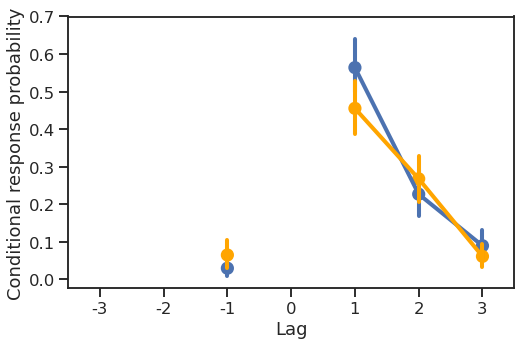

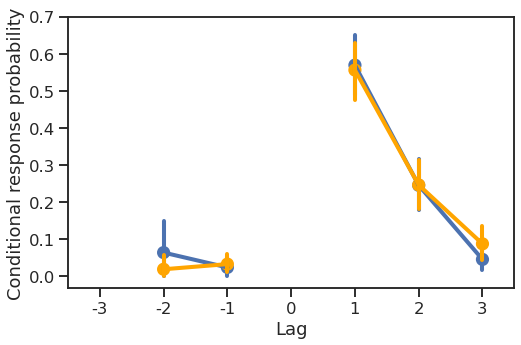

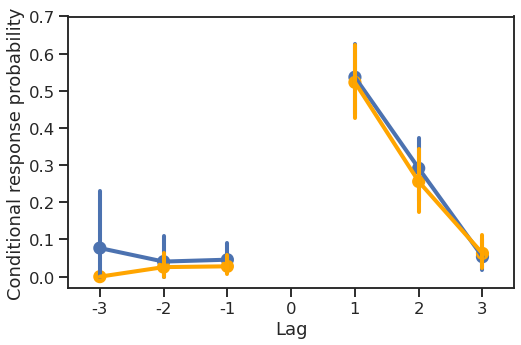

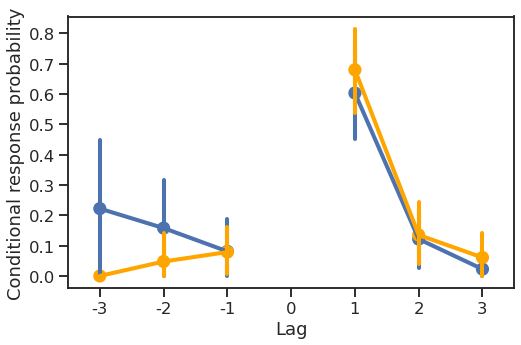

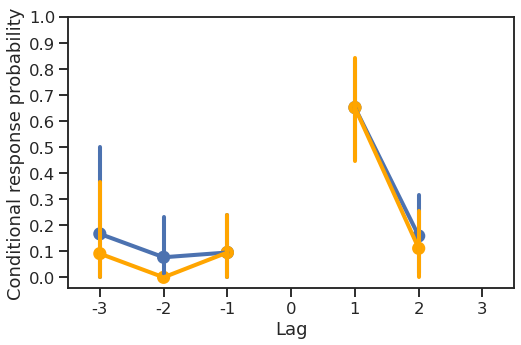

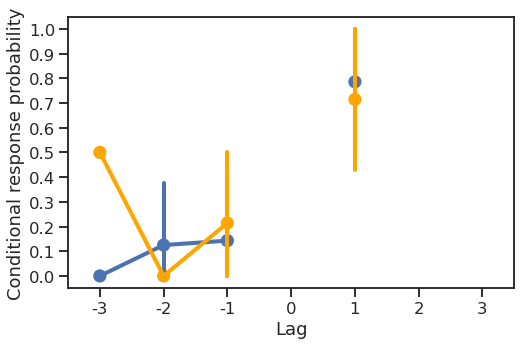

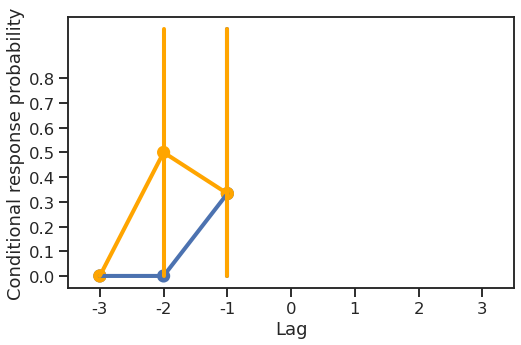

In [101]:
foeserposCRP3 = plt.figure(figsize = (8, 5))
ax1 = sns.pointplot(data=fwd_sp_foe3, x='lag', y='probability', marker = 'o')
ax2 = sns.pointplot(data=bwd_sp_foe3, x='lag', y='probability', marker = 'o', color = 'orange')
plt.xlabel('Lag')
plt.ylabel('Conditional response probability')
ax1.set_yticks([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7])
foeserposCRP3.savefig("./../graphsE5/EOS_CRPs/FOE_E2_EOS3.pdf", bbox_inches = 'tight',pad_inches = 0.2)

foeserposCRP4 = plt.figure(figsize = (8, 5))
ax1 = sns.pointplot(data=fwd_sp_foe4, x='lag', y='probability', marker = 'o')
ax2 = sns.pointplot(data=bwd_sp_foe4, x='lag', y='probability', marker = 'o', color = 'orange')
plt.xlabel('Lag')
plt.ylabel('Conditional response probability')
ax1.set_yticks([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7])
foeserposCRP4.savefig("./../graphsE5/EOS_CRPs/FOE_E2_EOS4.pdf", bbox_inches = 'tight',pad_inches = 0.2)

foeserposCRP5 = plt.figure(figsize = (8, 5))
ax1 = sns.pointplot(data=fwd_sp_foe5, x='lag', y='probability', marker = 'o')
ax2 = sns.pointplot(data=bwd_sp_foe5, x='lag', y='probability', marker = 'o', color = 'orange')
plt.xlabel('Lag')
plt.ylabel('Conditional response probability')
ax1.set_yticks([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7])
foeserposCRP5.savefig("./../graphsE5/EOS_CRPs/FOE_E2_EOS5.pdf", bbox_inches = 'tight',pad_inches = 0.2)

foeserposCRP6 = plt.figure(figsize = (8, 5))
ax1 = sns.pointplot(data=fwd_sp_foe6, x='lag', y='probability', marker = 'o')
ax2 = sns.pointplot(data=bwd_sp_foe6, x='lag', y='probability', marker = 'o', color = 'orange')
plt.xlabel('Lag')
plt.ylabel('Conditional response probability')
ax1.set_yticks([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8])
foeserposCRP6.savefig("./../graphsE5/EOS_CRPs/FOE_E2_EOS6.pdf", bbox_inches = 'tight',pad_inches = 0.2)

foeserposCRP7 = plt.figure(figsize = (8, 5))
ax1 = sns.pointplot(data=fwd_sp_foe7, x='lag', y='probability', marker = 'o')
ax2 = sns.pointplot(data=bwd_sp_foe7, x='lag', y='probability', marker = 'o', color = 'orange')
plt.xlabel('Lag')
plt.ylabel('Conditional response probability')
ax1.set_yticks([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
foeserposCRP7.savefig("./../graphsE5/EOS_CRPs/FOE_E2_EOS7.pdf", bbox_inches = 'tight',pad_inches = 0.2)

foeserposCRP8 = plt.figure(figsize = (8, 5))
ax1 = sns.pointplot(data=fwd_sp_foe8, x='lag', y='probability', marker = 'o')
ax2 = sns.pointplot(data=bwd_sp_foe8, x='lag', y='probability', marker = 'o', color = 'orange')
plt.xlabel('Lag')
plt.ylabel('Conditional response probability')
ax1.set_yticks([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
foeserposCRP8.savefig("./../graphsE5/EOS_CRPs/FOE_E2_EOS8.pdf", bbox_inches = 'tight',pad_inches = 0.2)

foeserposCRP9 = plt.figure(figsize = (8, 5))
ax1 = sns.pointplot(data=fwd_sp_foe9, x='lag', y='probability', marker = 'o')
ax2 = sns.pointplot(data=bwd_sp_foe9, x='lag', y='probability', marker = 'o', color = 'orange')
plt.xlabel('Lag')
plt.ylabel('Conditional response probability')
ax1.set_yticks([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8])
foeserposCRP9.savefig("./../graphsE5/EOS_CRPs/FOE_E2_EOS9.pdf", bbox_inches = 'tight',pad_inches = 0.2)

In [21]:
fwd_sp_foe = fwd_sp_foe.query('lag == -1')
bwd_sp_foe = bwd_sp_foe.query('lag == -1')

switch_dict = {1:9, 2:8, 3:7, 4:6, 5:5, 6:4, 7:3, 8:2, 9:1}


bwd_sp_foe['serpos']= bwd_sp_foe['serpos'].map(switch_dict)

foe_eop_tests = pd.merge(fwd_sp_foe, bwd_sp_foe, how = 'left', left_on = ['subject','serpos'], right_on = ['subject', 'serpos'])
foe_eop_tests.dropna(inplace = True)

In [22]:
foe_fillin_eop3 = stats.ttest_rel(foe_eop_tests[(foe_eop_tests.serpos == 3)].probability_x, foe_eop_tests[(foe_eop_tests.serpos == 3)].probability_y)[1]
foe_fillin_eop4 = stats.ttest_rel(foe_eop_tests[(foe_eop_tests.serpos == 4)].probability_x, foe_eop_tests[(foe_eop_tests.serpos == 4)].probability_y)[1]
foe_fillin_eop5 = stats.ttest_rel(foe_eop_tests[(foe_eop_tests.serpos == 5)].probability_x, foe_eop_tests[(foe_eop_tests.serpos == 5)].probability_y)[1]
foe_fillin_eop6 = stats.ttest_rel(foe_eop_tests[(foe_eop_tests.serpos == 6)].probability_x, foe_eop_tests[(foe_eop_tests.serpos == 6)].probability_y)[1]
foe_fillin_eop7 = stats.ttest_rel(foe_eop_tests[(foe_eop_tests.serpos == 7)].probability_x, foe_eop_tests[(foe_eop_tests.serpos == 7)].probability_y)[1]
foe_fillin_eop8 = stats.ttest_rel(foe_eop_tests[(foe_eop_tests.serpos == 8)].probability_x, foe_eop_tests[(foe_eop_tests.serpos == 8)].probability_y)[1]
foe_fillin_eop9 = stats.ttest_rel(foe_eop_tests[(foe_eop_tests.serpos == 9)].probability_x, foe_eop_tests[(foe_eop_tests.serpos == 9)].probability_y)[1]
eopfoe_fill_correct = [foe_fillin_eop3,foe_fillin_eop4,foe_fillin_eop5,foe_fillin_eop6,foe_fillin_eop7,foe_fillin_eop8,foe_fillin_eop9]
sm.stats.multitest.fdrcorrection(eopfoe_fill_correct, alpha = 0.05)

(array([False, False, False, False, False, False, False]),
 array([1., 1., 1., 1., 1., 1., 1.]))

## Recall Termination

In [104]:
fwd_OPcorrect_stop = pstop_OPCorrect(subs, 9, how = 'fwd')
bwd_OPcorrect_stop = pstop_OPCorrect(subs, 9, how = 'bwd')

In [105]:
catOP = pd.concat([fwd_OPcorrect_stop, bwd_OPcorrect_stop])

In [106]:
OPposneg = catOP.query('net_cor != 0')
OPposneg['cor_cat'] = OPposneg['net_cor'] > 0

In [107]:
OPposneg = OPposneg.groupby(['subject','how','outpos','cor_cat']).agg({'probability':'mean'}).reset_index()

In [108]:
OPposneg.to_csv('./../graphsE5/Stat_CSVs/OPposneg.csv')

## List Length Effects

### Recall Performance

In [192]:
ros6fwddiff = rosdiff(subs, 6, how = 'fwd')
ros7fwddiff = rosdiff(subs, 7, how = 'fwd')
ros8fwddiff = rosdiff(subs, 8, how = 'fwd')
ros9fwddiff = rosdiff(subs, 9, how = 'fwd')
ros10fwddiff = rosdiff(subs, 10, how = 'fwd')
ros11fwddiff = rosdiff(subs, 11, how = 'fwd')
ros12fwddiff = rosdiff(subs, 12, how = 'fwd')

ros6bwddiff = rosdiff(subs, 6, how = 'bwd')
ros7bwddiff = rosdiff(subs, 7, how = 'bwd')
ros8bwddiff = rosdiff(subs, 8, how = 'bwd')
ros9bwddiff = rosdiff(subs, 9, how = 'bwd')
ros10bwddiff = rosdiff(subs, 10, how = 'bwd')
ros11bwddiff = rosdiff(subs, 11, how = 'bwd')
ros12bwddiff = rosdiff(subs, 12, how = 'bwd')

In [193]:
rosfwd_diff = pd.concat([ros6fwddiff, ros7fwddiff, ros8fwddiff, ros9fwddiff, ros10fwddiff, ros11fwddiff, ros12fwddiff])
rosbwd_diff = pd.concat([ros6bwddiff, ros7bwddiff, ros8bwddiff, ros9bwddiff, ros10bwddiff, ros11bwddiff, ros12bwddiff])

In [194]:
ros_total = pd.concat([rosfwd_diff, rosbwd_diff])

ros_total['condition'] = '0'
for sub in ros_total.subject.unique():
    if sub in ros6fwddiff.subject.unique():
        ros_total.condition.loc[ros_total.subject == sub] = '1'
    elif sub in ros7fwddiff.subject.unique():
        ros_total.condition.loc[ros_total.subject == sub] = '2'
    elif sub in ros8fwddiff.subject.unique():
        ros_total.condition.loc[ros_total.subject == sub] = '3'

remove_na_ros = []
for number, subject in enumerate(ros_total.subject.loc[ros_total.probability.isna() == True]):
    remove_na_crp.append(subject)
ros_total = ros_total.query('subject not in @remove_na_ros')

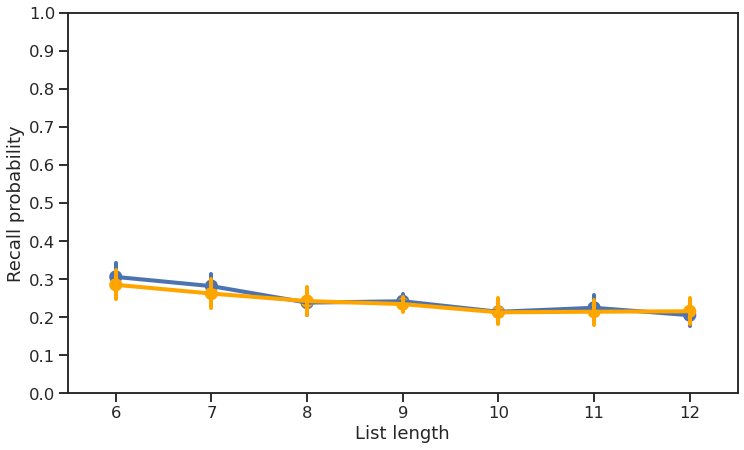

In [196]:
rosdiff_fig= plt.figure(figsize = (12, 7))
ax3 = sns.pointplot(data=ros_total.query('how == "fwd"'), x='list_length', y='probability', marker = 'o')
ax4 = sns.pointplot(data=ros_total.query('how == "bwd"'), x='list_length', y='probability', marker = 'o', color = 'orange')
plt.xlabel('List length')
plt.ylabel('Recall probability')
ax3.set_yticks([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
rosdiff_fig.savefig("./../graphsE5/rosdiff.pdf", bbox_inches = 'tight',pad_inches = 0.2)

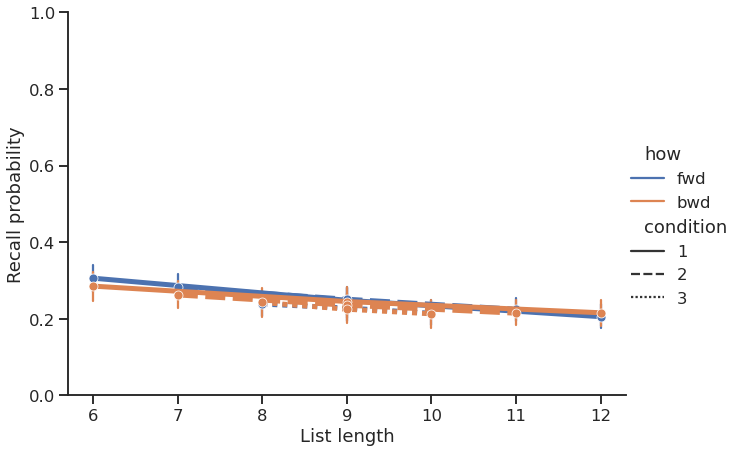

In [113]:
ax3 = sns.relplot(data=ros_total, x='list_length', y='probability', hue = 'how', marker = 'o',style = 'condition', 
                  kind = 'line', err_style = 'bars', height = 6, aspect = 1.5, linewidth = 5)
ax3.set(xticks = [6,7,8,9,10,11,12], ylim = [0,1.0], xlabel = 'List length', ylabel = 'Recall probability', title = '')
ax3.savefig("./../graphsE5/rosdiff.pdf")

In [114]:
switch_dict = {6:'short', 7:'short', 8:'short', 9:'medium',10:'long', 11:'long', 12:'long'}
ros_total['list_length'] = ros_total.list_length.map(switch_dict)
ros_total.to_csv('./../graphsE5/Stat_CSVs/Differences_ROS')

### Recall Initiation

In [198]:
pfr6fwd = pfr(subs, 6, how = 'fwd').query('x_values == 1')
pfr7fwd = pfr(subs, 7, how = 'fwd').query('x_values == 1')
pfr8fwd = pfr(subs, 8, how = 'fwd').query('x_values == 1')
pfr9fwd = pfr(subs, 9, how = 'fwd').query('x_values == 1')
pfr10fwd = pfr(subs, 10, how = 'fwd').query('x_values == 1')
pfr11fwd = pfr(subs, 11, how = 'fwd').query('x_values == 1')
pfr12fwd = pfr(subs, 12, how = 'fwd').query('x_values == 1')
pfr6bwd = pfr(subs, 6, how = 'bwd').query('x_values == 6')
pfr7bwd = pfr(subs, 7, how = 'bwd').query('x_values == 7')
pfr8bwd = pfr(subs, 8, how = 'bwd').query('x_values == 8')
pfr9bwd = pfr(subs, 9, how = 'bwd').query('x_values == 9')
pfr10bwd = pfr(subs, 10, how = 'bwd').query('x_values == 10')
pfr11bwd = pfr(subs, 11, how = 'bwd').query('x_values == 11')
pfr12bwd = pfr(subs, 12, how = 'bwd').query('x_values == 12')

In [199]:
pfr_fwd = pd.concat([pfr6fwd, pfr7fwd, pfr8fwd, pfr9fwd, pfr10fwd, pfr11fwd, pfr12fwd])
pfr_bwd = pd.concat([pfr6bwd, pfr7bwd, pfr8bwd, pfr9bwd, pfr10bwd, pfr11bwd, pfr12bwd])

In [200]:
pfr_total = pd.concat([pfr_fwd, pfr_bwd])
pfr_total['condition'] = '0'

for sub in pfr_total.subject.unique():
    if sub in pfr6fwd.subject.unique():
        pfr_total.condition.loc[pfr_total.subject == sub] = '1'
    elif sub in pfr7fwd.subject.unique():
        pfr_total.condition.loc[pfr_total.subject == sub] = '2'
    elif sub in pfr8fwd.subject.unique():
        pfr_total.condition.loc[pfr_total.subject == sub] = '3'
remove_na_pfr = []
for number, subject in enumerate(pfr_total.subject.loc[pfr_total.probability.isna() == True]):
    remove_na_pfr.append(subject)
pfr_total = pfr_total.query('subject not in @remove_na_pfr')

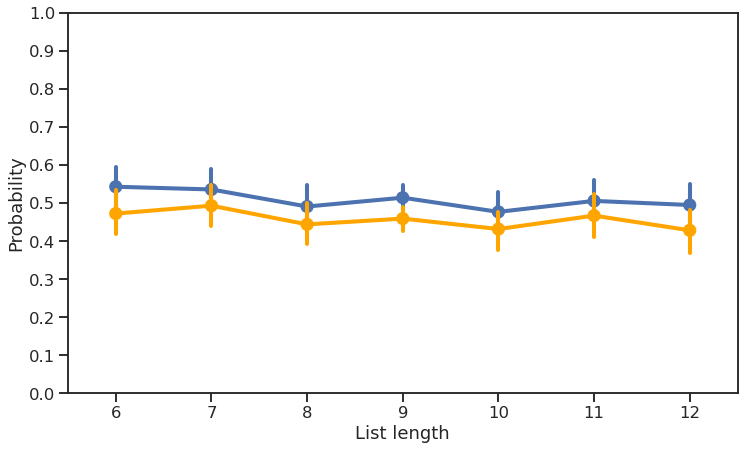

In [202]:
pfr_diff_fig= plt.figure(figsize = (12, 7))
ax1 = sns.pointplot(data=pfr_total.query('how == "fwd"'), x='list_length', y='probability', marker = 'o')
ax2 = sns.pointplot(data=pfr_total.query('how == "bwd"'), x='list_length', y='probability', marker = 'o', color = 'orange')
plt.xlabel('List length')
plt.ylabel('Probability')
ax1.set_yticks([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
pfr_diff_fig.savefig("./../graphsE5/pfr_diff.pdf", bbox_inches = 'tight',pad_inches = 0.2)

In [ ]:
ax3 = sns.relplot(data=pfr_total, x='list_length', y='probability', hue = 'how', marker = 'o',style = 'condition', 
                  kind = 'line', err_style = 'bars', height = 6, aspect = 1.5, linewidth = 5)
ax3.set(xticks = [6,7,8,9,10,11,12], ylim = [0,1.0], xlabel = 'List length', ylabel = 'Recall probability', title = '')
ax3.savefig("./../graphsE5/pfr_diff.pdf", bbox_inches = 'tight',pad_inches = 0.2)

In [120]:
switch_dict = {6:'short', 7:'short', 8:'short', 9:'medium',10:'long', 11:'long', 12:'long'}
pfr_total['list_length'] = pfr_total.list_length.map(switch_dict)
pfr_total.to_csv('./../graphsE5/Stat_CSVs/Differences_PFR')

### Recall Transitions

In [203]:
crp6fwd = lagCRP_curve(subs, 6, how = 'fwd').query('x_values == -1')
crp7fwd = lagCRP_curve(subs, 7, how = 'fwd').query('x_values == -1')
crp8fwd = lagCRP_curve(subs, 8, how = 'fwd').query('x_values == -1')
crp9fwd = lagCRP_curve(subs, 9, how = 'fwd').query('x_values == -1')
crp10fwd = lagCRP_curve(subs, 10, how = 'fwd').query('x_values == -1')
crp11fwd = lagCRP_curve(subs, 11, how = 'fwd').query('x_values == -1')
crp12fwd = lagCRP_curve(subs, 12, how = 'fwd').query('x_values == -1')
crp6bwd = lagCRP_curve(subs, 6, how = 'bwd').query('x_values == -1')
crp7bwd = lagCRP_curve(subs, 7, how = 'bwd').query('x_values == -1')
crp8bwd = lagCRP_curve(subs, 8, how = 'bwd').query('x_values == -1')
crp9bwd = lagCRP_curve(subs, 9, how = 'bwd').query('x_values == -1')
crp10bwd = lagCRP_curve(subs, 10, how = 'bwd').query('x_values == -1')
crp11bwd = lagCRP_curve(subs, 11, how = 'bwd').query('x_values == -1')
crp12bwd = lagCRP_curve(subs, 12, how = 'bwd').query('x_values == -1')

In [204]:
crpfwd = pd.concat([crp6fwd, crp7fwd, crp8fwd, crp9fwd, crp10fwd, crp11fwd, crp12fwd])
crpbwd = pd.concat([crp6bwd, crp7bwd, crp8bwd, crp9bwd, crp10bwd, crp11bwd, crp12bwd])

In [205]:
crp_total = pd.concat([crpfwd, crpbwd])

crp_total['condition'] = '0'
for sub in crp_total.subject.unique():
    if sub in crp6fwd.subject.unique():
        crp_total.condition.loc[crp_total.subject == sub] = '1'
    elif sub in crp7fwd.subject.unique():
        crp_total.condition.loc[crp_total.subject == sub] = '2'
    elif sub in crp8fwd.subject.unique():
        crp_total.condition.loc[crp_total.subject == sub] = '3'

remove_na_crp = []
for number, subject in enumerate(crp_total.subject.loc[crp_total.probability.isna() == True]):
    remove_na_crp.append(subject)
    
crp_total = crp_total.query('subject not in @remove_na_crp')

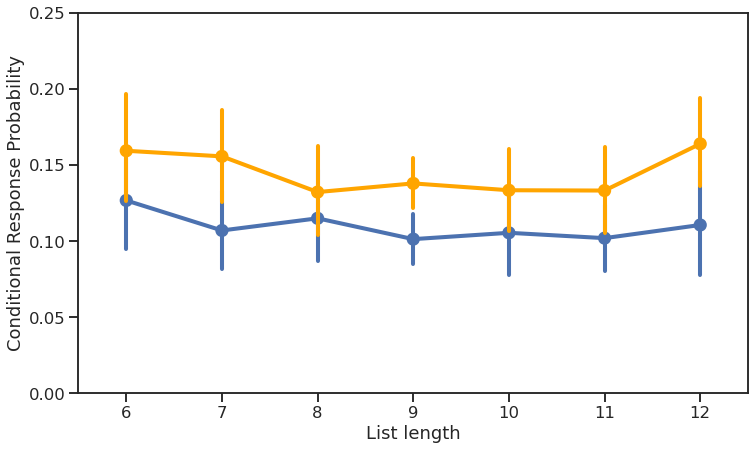

In [206]:
crpdiff_fig= plt.figure(figsize = (12, 7))
ax3 = sns.pointplot(data=crp_total.query('how == "fwd"'), x='list_length', y='probability', marker = 'o')
ax4 = sns.pointplot(data=crp_total.query('how == "bwd"'), x='list_length', y='probability', marker = 'o', color = 'orange')
plt.xlabel('List length')
plt.ylabel('Conditional Response Probability')
ax3.set_yticks([0.00, 0.05, 0.10, 0.15, 0.20, 0.25])
crpdiff_fig.savefig("./../graphsE5/crpdiff.pdf", bbox_inches = 'tight',pad_inches = 0.2)

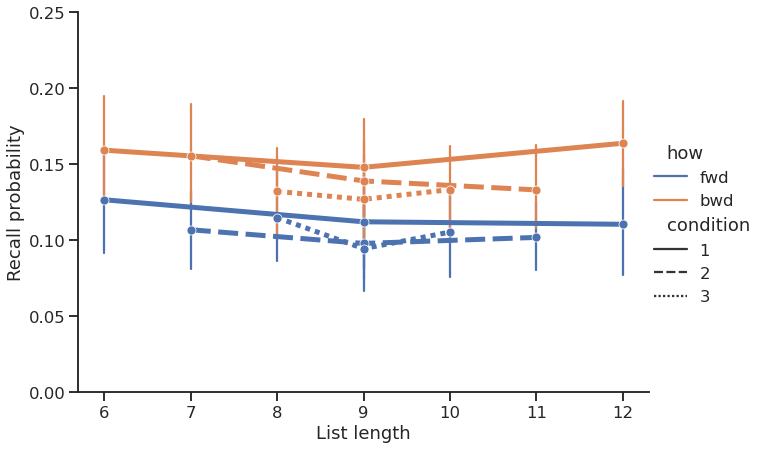

In [125]:
ax3 = sns.relplot(data=crp_total, x='list_length', y='probability', hue = 'how', marker = 'o',style = 'condition', 
                  kind = 'line', err_style = 'bars', height = 6, aspect = 1.5, linewidth = 5)
ax3.set(xticks = [6,7,8,9,10,11,12], ylim = [0,0.25], xlabel = 'List length', ylabel = 'Recall probability', title = '')
ax3.savefig("./../graphsE5/crp_diff.pdf", bbox_inches = 'tight',pad_inches = 0.2)

In [126]:
switch_dict = {6:'short', 7:'short', 8:'short', 9:'medium',10:'long', 11:'long', 12:'long'}        
crp_total['list_length'] = crp_total.list_length.map(switch_dict)
crp_total.to_csv('./../graphsE5/Stat_CSVs/Differences_CRP')

## Inter-Response Time

In [3]:
IRT = find_perfectstart(subs, number_at_start = 4)
IRT['IRT'] = 999
for i in list(range(IRT.shape[0])):
    if i == 0:
        IRT.IRT.iloc[i] = float("NaN")
    if i != 0:
        IRT.IRT.iloc[i] = IRT.mstime.iloc[i] - IRT.mstime.iloc[i - 1] 
IRT.IRT = IRT.IRT/1000
IRT = IRT.query('type == "REC_WORD"')

/home1/doughem/.conda/envs/AnalysisEnv/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [4]:
oneD_subs = []
for sub in IRT.subject.unique():
    sub_df = IRT.query('subject == @sub')
    if len(sub_df.how.unique()) == 1:
        oneD_subs.append(sub)

In [5]:
win_sub_IRT = IRT.groupby(['subject','how','outpos','list_length']).agg({'IRT':'mean'}).reset_index()
win_sub_IRT = win_sub_IRT.query('subject not in @oneD_subs')

In [6]:
fwd_times = win_sub_IRT.query('outpos != 1.0 & how =="fwd"').groupby(['subject', 'how', 'list_length']).agg({'IRT':'mean'}).reset_index()
bwd_times = win_sub_IRT.query('outpos != 1.0 & how =="bwd"').groupby(['subject', 'how', 'list_length']).agg({'IRT':'mean'}).reset_index()
fwd_start = win_sub_IRT.query('outpos == 1.0 & how =="fwd"').groupby(['subject', 'how', 'list_length']).agg({'IRT':'mean'}).reset_index()
bwd_start = win_sub_IRT.query('outpos == 1.0 & how =="bwd"').groupby(['subject', 'how', 'list_length']).agg({'IRT':'mean'}).reset_index()
merged_times = fwd_times.merge(bwd_times, on = ['subject', 'list_length'], suffixes = ['_fwd', '_bwd'])
merged_times['diff'] = merged_times['IRT_fwd'] - merged_times['IRT_bwd']
merged_start = fwd_start.merge(bwd_start, on = ['subject', 'list_length'], suffixes = ['_fwd', '_bwd'])
merged_start['diff'] = merged_start['IRT_fwd'] - merged_start['IRT_bwd']

In [19]:
#Separate by list length, query each list length, recombine
fwd_start6 = fwd_start.query('list_length == 6')
bwd_start6 = bwd_start.query('list_length == 6 & subject in @fwd_start6.subject.unique()')
fwd_start6 = fwd_start6.query('subject in @bwd_start6.subject.unique()')

fwd_start7 = fwd_start.query('list_length == 7')
bwd_start7 = bwd_start.query('list_length == 7 & subject in @fwd_start7.subject.unique()')
fwd_start7 = fwd_start7.query('subject in @bwd_start7.subject.unique()')

fwd_start8 = fwd_start.query('list_length == 8')
bwd_start8 = bwd_start.query('list_length == 8 & subject in @fwd_start8.subject.unique()')
fwd_start8 = fwd_start8.query('subject in @bwd_start8.subject.unique()')

fwd_start9 = fwd_start.query('list_length == 9')
bwd_start9 = bwd_start.query('list_length == 9 & subject in @fwd_start9.subject.unique()')
fwd_start9 = fwd_start9.query('subject in @bwd_start9.subject.unique()')

fwd_start10 = fwd_start.query('list_length == 10')
bwd_start10 = bwd_start.query('list_length == 10 & subject in @fwd_start10.subject.unique()')
fwd_start10 = fwd_start10.query('subject in @bwd_start10.subject.unique()')

fwd_start11 = fwd_start.query('list_length == 11')
bwd_start11 = bwd_start.query('list_length == 11 & subject in @fwd_start11.subject.unique()')
fwd_start11 = fwd_start11.query('subject in @bwd_start11.subject.unique()')

fwd_start12 = fwd_start.query('list_length == 12')
bwd_start12 = bwd_start.query('list_length == 12 & subject in @fwd_start12.subject.unique()')
fwd_start12 = fwd_start12.query('subject in @bwd_start12.subject.unique()')

In [20]:
#Separate by list length, query each list length, recombine
fwd_times6 = fwd_times.query('list_length == 6')
bwd_times6 = bwd_times.query('list_length == 6 & subject in @fwd_times6.subject.unique()')
fwd_times6 = fwd_times6.query('subject in @bwd_times6.subject.unique()')

fwd_times7 = fwd_times.query('list_length == 7')
bwd_times7 = bwd_times.query('list_length == 7 & subject in @fwd_times7.subject.unique()')
fwd_times7 = fwd_times7.query('subject in @bwd_times7.subject.unique()')

fwd_times8 = fwd_times.query('list_length == 8')
bwd_times8 = bwd_times.query('list_length == 8 & subject in @fwd_times8.subject.unique()')
fwd_times8 = fwd_times8.query('subject in @bwd_times8.subject.unique()')

fwd_times9 = fwd_times.query('list_length == 9')
bwd_times9 = bwd_times.query('list_length == 9 & subject in @fwd_times9.subject.unique()')
fwd_times9 = fwd_times9.query('subject in @bwd_times9.subject.unique()')

fwd_times10 = fwd_times.query('list_length == 10')
bwd_times10 = bwd_times.query('list_length == 10 & subject in @fwd_times10.subject.unique()')
fwd_times10 = fwd_times10.query('subject in @bwd_times10.subject.unique()')

fwd_times11 = fwd_times.query('list_length == 11')
bwd_times11 = bwd_times.query('list_length == 11 & subject in @fwd_times11.subject.unique()')
fwd_times11 = fwd_times11.query('subject in @bwd_times11.subject.unique()')

fwd_times12 = fwd_times.query('list_length == 12')
bwd_times12 = bwd_times.query('list_length == 12 & subject in @fwd_times12.subject.unique()')
fwd_times12 = fwd_times12.query('subject in @bwd_times12.subject.unique()')

In [21]:
stat_start = fwd_start6.append([bwd_start6, fwd_start7, bwd_start7, fwd_start8, bwd_start8, fwd_start9, bwd_start9, fwd_start10, bwd_start10, fwd_start11, bwd_start11, fwd_start12, bwd_start12])
stat_times = fwd_times6.append([bwd_times6, fwd_times7, bwd_times7, fwd_times8, bwd_times8, fwd_times9, bwd_times9, fwd_times10, bwd_times10, fwd_times11, bwd_times11, fwd_times12, bwd_times12])
stat_times.to_csv('./../graphsE5/Stat_CSVs/IRT_transitions.csv')
stat_start.to_csv('./../graphsE5/Stat_CSVs/IRT_starts.csv')

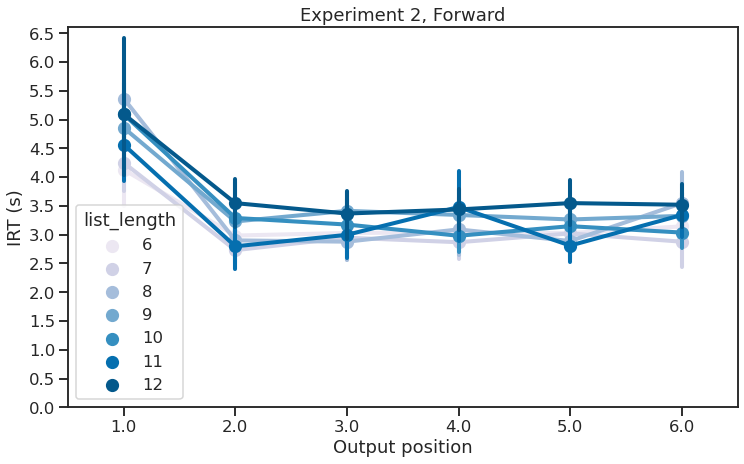

In [53]:
IRT_fig = plt.figure(figsize = (12, 7))
ax1 = sns.pointplot(data = win_sub_IRT.query('how == "fwd"'), x='outpos', y='IRT', marker = 'o', hue = 'list_length',palette = 'PuBu')
plt.xlabel('Output position')
plt.ylabel('IRT (s)')
ax1.set_yticks([0.00, 0.50, 1.00, 1.50, 2.00, 2.50, 3.00, 3.50, 4.00, 4.50, 5.00, 5.50, 6.0, 6.50])
plt.title('Experiment 2, Forward')
IRT_fig.savefig('./../graphsE5/IRTs_all_fwd.pdf', bbox_inches = 'tight')

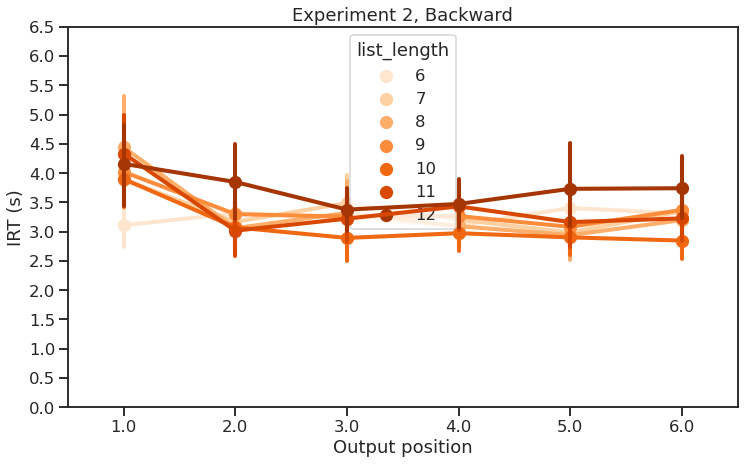

In [52]:
IRT_fig = plt.figure(figsize = (12, 7))
ax1 = sns.pointplot(data = win_sub_IRT.query('how == "bwd"'), x='outpos', y='IRT', marker = 'o', hue = 'list_length', palette = 'Oranges')
plt.xlabel('Output position')
plt.ylabel('IRT (s)')
ax1.set_yticks([0.00, 0.50, 1.00, 1.50, 2.00, 2.50, 3.00, 3.50, 4.00, 4.50, 5.00, 5.50, 6.0, 6.50])
plt.title('Experiment 2, Backward')
IRT_fig.savefig('./../graphsE5/IRTs_all_bwd.pdf', bbox_inches = 'tight')

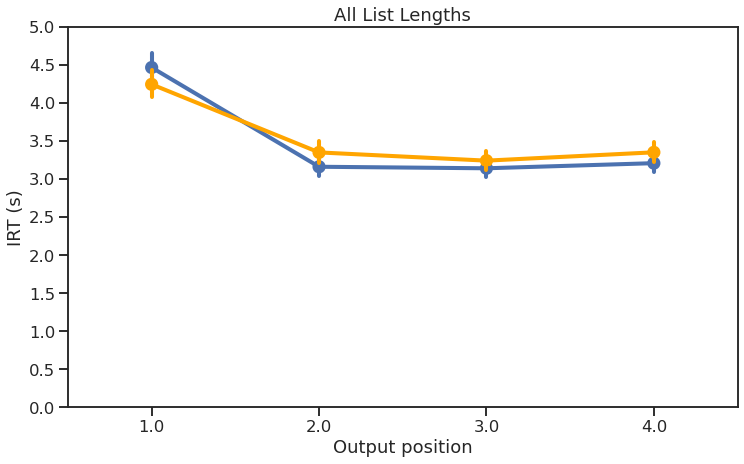

In [ ]:
IRT_fig = plt.figure(figsize = (12, 7))
ax1 = sns.pointplot(data = win_sub_IRT.query('how == "fwd"'), x='outpos', y='IRT', marker = 'o')
ax2 = sns.pointplot(data = win_sub_IRT.query('how == "bwd"'), x='outpos', y='IRT', marker = 'o', color = 'orange')
plt.xlabel('Output position')
plt.ylabel('IRT (s)')
ax2.set_yticks([0.00, 0.50, 1.00, 1.50, 2.00, 2.50, 3.00, 3.50, 4.00, 4.50, 5.00])
plt.title('All List Lengths')
IRT_fig.savefig('./../graphsE5/IRTs.pdf', bbox_inches = 'tight')

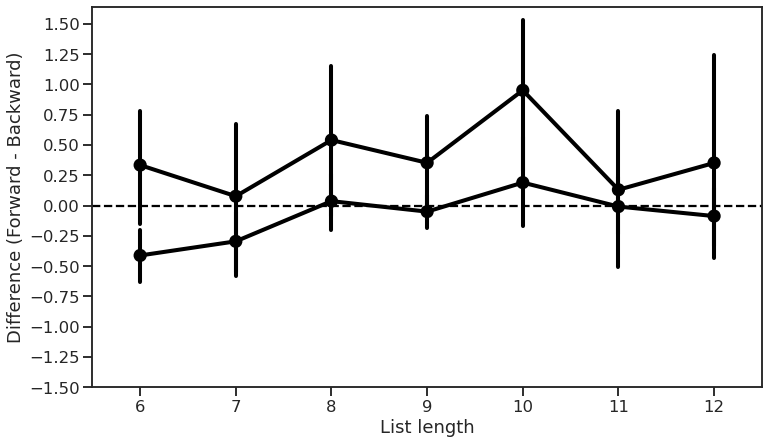

In [7]:
IRT_fig = plt.figure(figsize = (12, 7))
plt.axhline(y = 0, color = 'black', linestyle = '--')
ax1 = sns.pointplot(data = merged_times, x='list_length', y='diff', color = 'black', markers = "o")
ax2 = sns.pointplot(data = merged_start, x='list_length', y='diff', color = 'black', markers = 'o')
plt.xlabel('List length')
plt.ylabel('Difference (Forward - Backward)')
ax1.set_yticks([-1.50, -1.25, -1.00, -0.75, -0.50, -0.25, 0.00, 0.25, 0.50, 0.75, 1.00, 1.25, 1.50])
IRT_fig.savefig('./../graphsE5/IRT_LL.pdf', bbox_inches = 'tight')

Text(0, 0.5, 'Difference (Forward - Backward)')

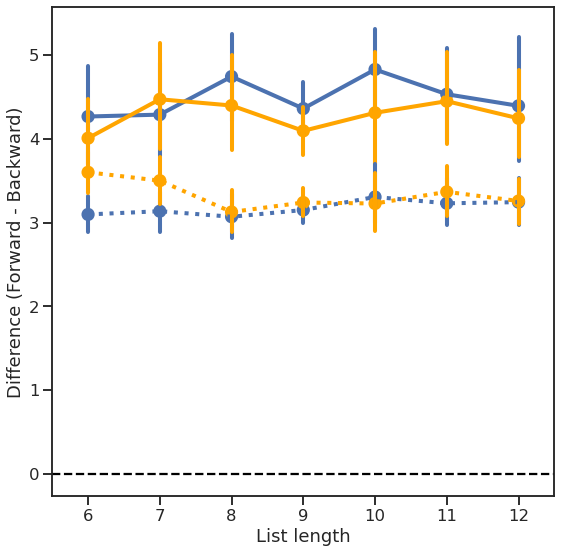

In [14]:
IRT_fig = plt.figure(figsize = (9, 9))
plt.axhline(y = 0, color = 'black', linestyle = '--')
ax1 = sns.pointplot(data = fwd_start, x='list_length', y='IRT', markers = "o")
ax2 = sns.pointplot(data = bwd_start, x='list_length', y='IRT', color = 'orange', markers = 'o')
ax3 = sns.pointplot(data = fwd_times, x='list_length', y='IRT', linestyles=':')
ax4 = sns.pointplot(data = bwd_times, x='list_length', y='IRT', color = 'orange', linestyles=':')
plt.xlabel('List length')
plt.ylabel('Difference (Forward - Backward)')
# ax1.set_yticks([-1.50, -1.25, -1.00, -0.75, -0.50, -0.25, 0.00, 0.25, 0.50, 0.75, 1.00, 1.25, 1.50])
# IRT_fig.savefig('./../graphsE5/IRT_LL.pdf', bbox_inches = 'tight')

In [149]:
win_sub_IRT = win_sub_IRT.groupby(['subject', 'outpos', 'how']).agg({'IRT':'mean'})

In [207]:
irt_t1 = stats.ttest_rel(win_sub_IRT.query('how == "fwd" & outpos == 1.0').IRT, win_sub_IRT.query('how == "bwd" & outpos == 1.0').IRT)[1]
irt_t2 = stats.ttest_rel(win_sub_IRT.query('how == "fwd" & outpos == 2.0').IRT, win_sub_IRT.query('how == "bwd" & outpos == 2.0').IRT)[1]
irt_t3 = stats.ttest_rel(win_sub_IRT.query('how == "fwd" & outpos == 3.0').IRT, win_sub_IRT.query('how == "bwd" & outpos == 3.0').IRT)[1]
irt_t4 = stats.ttest_rel(win_sub_IRT.query('how == "fwd" & outpos == 4.0').IRT, win_sub_IRT.query('how == "bwd" & outpos == 4.0').IRT)[1]
irt_correct = [irt_t1, irt_t2, irt_t3, irt_t4]
sm.stats.multitest.fdrcorrection(irt_correct, alpha = 0.05)

(array([False, False, False, False]),
 array([0.30303305, 0.30303305, 0.81502541, 0.30303305]))

In [151]:
win_sub_IRT.to_csv('./../graphsE5/Stat_CSVs/IRT.csv')

## Comparing Data for Empty and Confused Lists

In [ ]:
confused_subs = find_incorrect(subs)

In [ ]:
confused_edit = confused_subs.query('type == "END_RECALL"').reset_index(drop = True)

In [ ]:
confused_edit['fwd_confused'] = (confused_edit['how'] == 'fwd') & (confused_edit['executed_dir'] == 'bwd')
confused_edit['bwd_confused'] = (confused_edit['how'] == 'bwd') & (confused_edit['executed_dir'] == 'fwd')

In [ ]:
print(confused_edit.groupby('subject').agg({'fwd_confused':'mean'}).reset_index().fwd_confused.mean())
print(confused_edit.groupby('subject').agg({'bwd_confused':'mean'}).reset_index().bwd_confused.mean())

In [ ]:
confused_edit = confused_subs.query('type == "END_RECALL" & executed_dir in ["fwd","bwd"]').reset_index(drop = True)
confused_edit['confused'] = confused_edit['how'] != confused_edit['executed_dir']
confused_edit['listno'] = confused_edit['listno'].astype(str)
confused_edit['flag'] = confused_edit['subject'] + confused_edit['listno']
confused_edit = confused_edit.query('confused == True')
subs['listno'] = subs['listno'].astype(str)
subs['flag'] = subs['subject'] + subs['listno']
mod_subs = subs.query('flag not in @confused_edit.flag')

In [ ]:
mod_subs9 = mod_subs.query('list_length == 9')
rec_subs = mod_subs9.query('rel_recall == 1')
word_subs = mod_subs9.query('type == "WORD"')
solway_rate_df = pd.DataFrame(columns = ['rec_rate', 'bwd_rec_rate'])
for sub in mod_subs9.subject.unique():
    rec_sub_df = rec_subs.query('subject == @sub')
    word_sub_df = word_subs.query('subject == @sub')
    if word_sub_df.query('how == "fwd"').shape[0] == 0:
        continue
    if word_sub_df.query('how == "bwd"').shape[0] == 0:
        continue
    helper_list = []
    helper_list.append(sub)
    helper_list.append(rec_sub_df.shape[0]/word_sub_df.shape[0])
    solway_rate_df = solway_rate_df.append(pd.Series(helper_list, index = ['subject', 'rec_rate']), ignore_index = True)

In [ ]:
print(solway_rate_df.rec_rate.mean())

## Comparing Data Based on Notes Answers

In [ ]:
#Read-in of CSV if you want to avoid re-cleaning data.
wrote_subs = pd.read_csv('fullsubsE5_wrotenotes.csv', index_col = 'index')

In [ ]:
print(len(wrote_subs.subject.unique()))

### SPC

In [ ]:
solwayfwd = ros(subs, 9, how = 'fwd')
solwaybwd = ros(subs, 9, how = 'bwd', flip_bwd = True)
solwayfwd_WN = ros(wrote_subs, 9, how = 'fwd')
solwaybwd_WN = ros(wrote_subs, 9, how = 'bwd', flip_bwd = True)

In [ ]:
solwayfig = plt.figure(figsize = (12, 7))
ax1 = sns.pointplot(data=solwayfwd, x='x_values', y='probability', marker = 'o')
ax2 = sns.pointplot(data=solwaybwd, x='x_values', y='probability', marker = 'o', color = 'orange')
ax5 = sns.pointplot(data=solwayfwd_WN, x='x_values', y='probability', marker = 'o', linestyles = ':')
ax6 = sns.pointplot(data=solwaybwd_WN, x='x_values', y='probability', marker = 'o', color = 'orange', linestyles = ':')
plt.xlabel('Output position')
plt.ylabel('Recall probability')
ax1.set_yticks([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
solwayfig.savefig("./../graphsE5/Notes_SPC2.pdf", bbox_inches = 'tight',pad_inches = 0.2)

### PFR

In [ ]:
pfrfwd9 = pfr(subs, 9, how = 'fwd')
pfrbwd9flip = pfr(subs, 9, how = 'bwd', flip_bwd = True)
pfrfwd9_WN = pfr(wrote_subs, 9, how = 'fwd')
pfrbwd9flip_WN = pfr(wrote_subs, 9, how = 'bwd', flip_bwd = True)

In [ ]:
pfr_op = plt.figure(figsize = (12, 7))
ax1 = sns.pointplot(data=pfrfwd9, x='x_values', y='probability', marker = 'o')
ax2 = sns.pointplot(data=pfrbwd9flip, x='x_values', y='probability', marker = 'o', color = 'orange')
ax5 = sns.pointplot(data=pfrfwd9_WN, x='x_values', y='probability', marker = 'o', linestyles = ':')
ax6 = sns.pointplot(data=pfrbwd9flip_WN, x='x_values', y='probability', marker = 'o', color = 'orange', linestyles = ':')
plt.xlabel('Expected output position')
plt.ylabel('Recall probability')
ax5.set_yticks([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
pfr_op.savefig("./../graphsE5/Notes_PFR2.pdf", bbox_inches = 'tight',pad_inches = 0.2)

### CRP

In [ ]:
crp9fwd = lagCRP_curve(subs, 9, how = 'fwd')
crp9bwd = lagCRP_curve(subs, 9, how = 'bwd')
crp9fwd_WN = lagCRP_curve(wrote_subs, 9, how = 'fwd')
crp9bwd_WN = lagCRP_curve(wrote_subs, 9, how = 'bwd')

In [ ]:
crp9fig= plt.figure(figsize = (12, 7))
ax1 = sns.pointplot(data=crp9fwd, x='x_values', y='probability')
ax2 = sns.pointplot(data=crp9fwd_WN, x='x_values', y='probability', linestyles = ':')
ax3 = sns.pointplot(data=crp9bwd_WN, x='x_values', y='probability', color = 'orange', linestyles = ':')
ax4 = sns.pointplot(data=crp9bwd, x='x_values', y='probability',  color = 'orange')
plt.xlabel('Lag')
plt.ylabel('Conditional response probability')
ax1.set_yticks([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6])
plt.title('List Length 9 Lag-CRP Curve')
crp9fig.savefig("./../graphsE5/Notes_CRP2.pdf", bbox_inches = 'tight',pad_inches = 0.2)